In [1]:
import imp
import uproot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
helper = imp.load_source('helpfunction','/home/tmettler/Desktop/uBoone/do_plots/helpfunction.py')
#import /home/tmettler/Desktop/uBoone/do_plots/helpfunction as helper
from __future__ import division

import collections
NuCC = imp.load_source('NuCC_function','/home/tmettler/Desktop/uBoone/do_plots/NuCC_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
!jupyter nbconvert --to script numuCCana_crt_cut_V3.ipynb

[NbConvertApp] Converting notebook numuCCana_crt_cut_V3.ipynb to script
[NbConvertApp] Writing 64707 bytes to numuCCana_crt_cut_V3.py


In [3]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [14]:
# Load input files

inputdir = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/'
outputdir = inputdir+'NumuCC_crt_cut/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

filename_overlay = 'NuCCana_Overlay_V18_V3.root'
filename_data = 'NuCCana_Data_V16_V3.root'
filename_ext = 'NuCCana_Ext_V18_V3.root'
filename_dirt = 'NuCCana_Dirt_V20_V3.root'
    
tree_name = 'numuCCAna'

In [15]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

pot_data =      8.039e+18 # tor860_wcut
data_trigger = 1942081.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  25882118.0  #2120135 #5685315 # EXT
'''
pot_data =     1.25795274297e+18# tor860_wcut
data_trigger = 1359818.0*0.4 # E1DCNT
ext_trigger =  1359818.0  #2120135 #5685315 # EXT
pot_overlay = 1.25795274297e+18/0.5
pot_dirt = 1.25795274297e18/0.04
'''
print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]*1.3
scale[overlay] = scale[overlay]*1.3
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	967268
Data: Number of Entries:	34835
Ext: Number of Entries:		302778
Dirt: Number of Entries:	96465

POT: 
Data:		8.039e+18
Ext:		0
Overlay:	1.21191661343e+21
Dirt:		2.9866803255e+20

Scalefactors: 
Data:		1.0
Ext:		0.0750356288461
Overlay:	0.00862328305772
Dirt:		0.0349910230123


In [6]:
if 1:
    filename_overlay = 'NuCCana_Overlay_V18_V3.rootout.root'
    filename_data = 'NuCCana_Data_V16_V3.rootout.root'
    filename_ext = 'NuCCana_Ext_V18_V3.rootout.root'
    filename_dirt = 'NuCCana_Dirt_V20_V3.rootout.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]*1.3
    scale_out[overlay_out] = scale_out[overlay_out]*1.3

Overlay: Number of Entries:	967267
Data: Number of Entries:	34834
Ext: Number of Entries:		302777
Dirt: Number of Entries:	96464



In [7]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG==13 && MCle_purity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG!=13 && MCle_purity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_purity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [8]:
for x in sample_out:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    #num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
#tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
#overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
# Load the global variables for access of functions

NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [10]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [11]:
track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")


True

First mean: -1.01815198655
First std: 0.491950086921
First mean: 0.00781328501561
First std: 0.525220397479
First mean: -0.318246658596
First std: 0.61351665599
 FCN=114938 FROM MIGRAD    STATUS=CONVERGED     114 CALLS         115 TOTAL
                     EDM=4.00579e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.13848e+04   3.50711e+01   1.02385e-01  -2.61847e-06
   2  Mean        -1.01815e+00   8.30486e-04   5.43820e-07   1.00831e-02
   3  Sigma        4.91950e-01   1.26789e-03  -1.56004e-06  -4.32733e-01
 FCN=121846 FROM MIGRAD    STATUS=CONVERGED     118 CALLS         119 TOTAL
                     EDM=2.20866e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVA

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_Vx.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_Vx.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_Vy.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_Vy.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_Vz.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_Vz.root has b

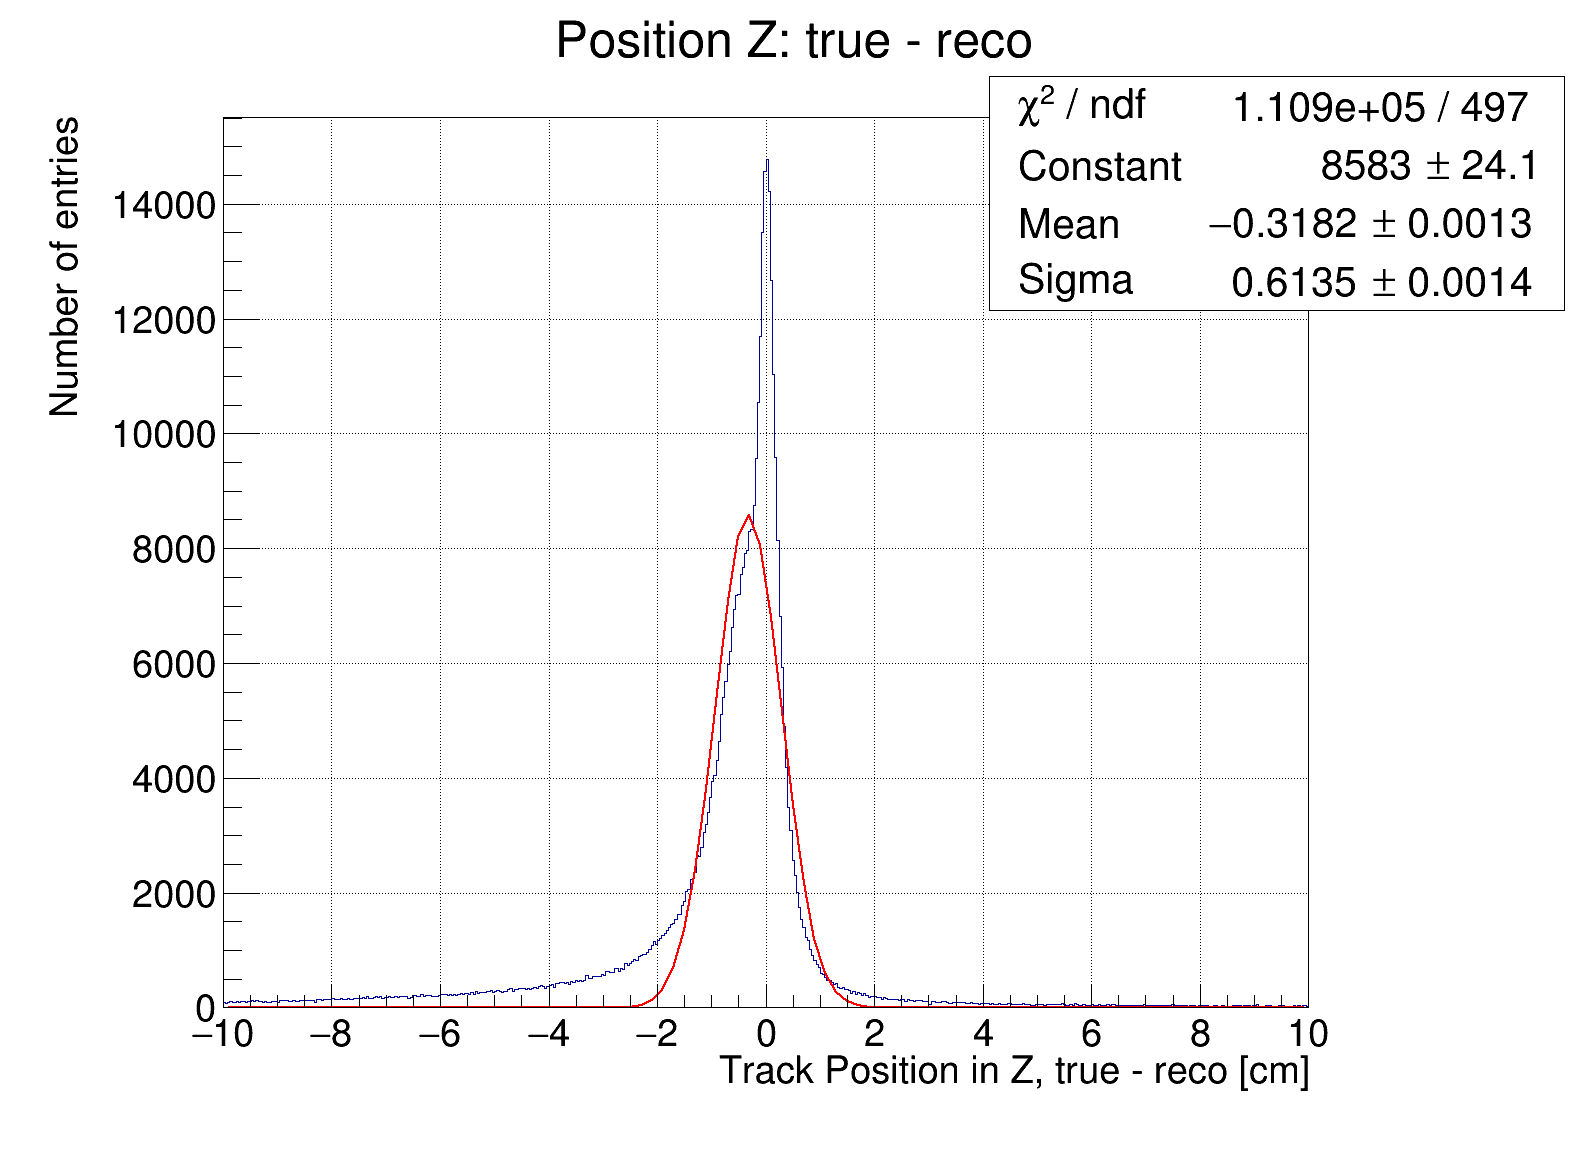

In [12]:
title = 'Position X: true - reco'
name = 'Vx'
xstart = -10
xend = 10
xbin = 500
%jsroot off
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_Vx-TrackStart_x_sce>>h_pos','MCle_Vx!=-999 && fidVol')
h_pos.SetXTitle("Track Position in X, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

title = 'Position Y: true - reco'
name = 'Vy'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_Vy-TrackStart_y_sce>>h_pos','MCle_Vy!=-999  && fidVol')
h_pos.SetXTitle("Track Position in Y, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

title = 'Position Z: true - reco'
name = 'Vz'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_Vz-TrackStart_z_sce>>h_pos','MCle_Vz!=-999 && fidVol')
h_pos.SetXTitle("Track Position in Z, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_MCS_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_MCS_tracklength.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_range_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_range_tracklength.root has been created


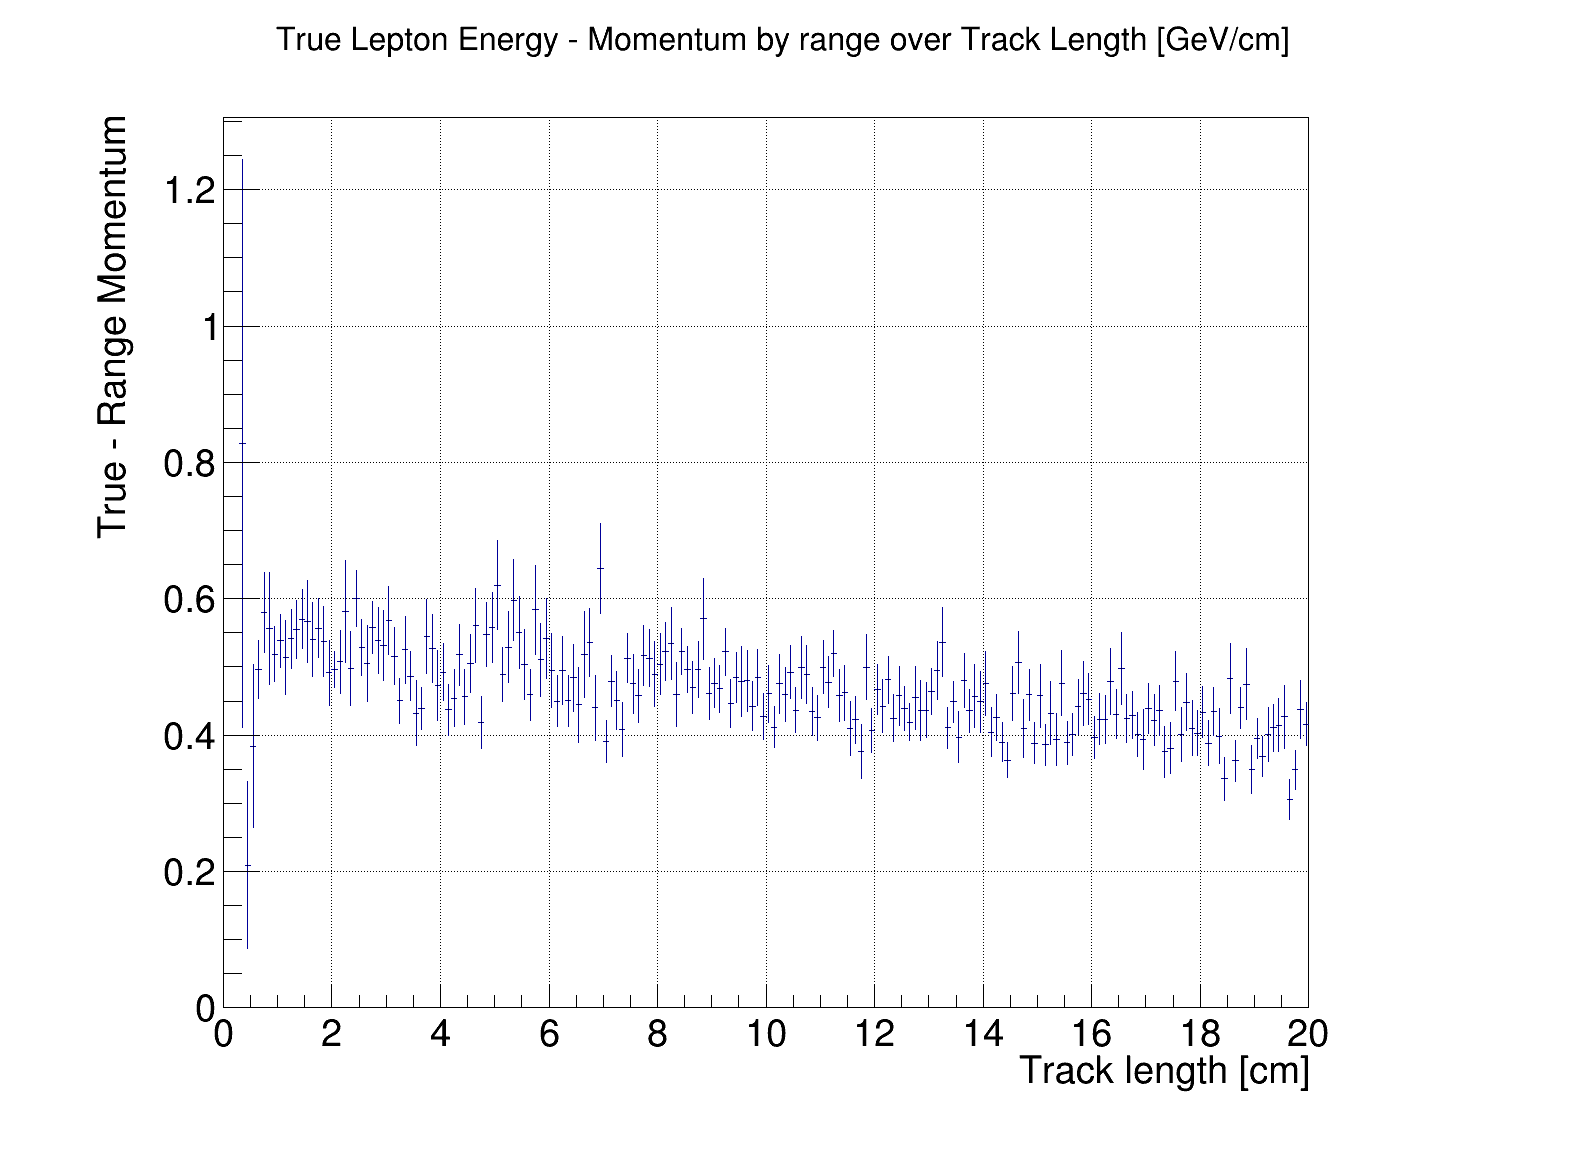

In [12]:
title = 'True Lepton Energy - MCS over Track Length [GeV/cm]'
xstart = 0
xend = 20
xbin = 200
ystart = -1
yend = 1
ybin = 200
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
#h_pos = ROOT.TH2F("h_pos",title,xbin,xstart,xend,ybin, ystart, yend)
#h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos = ROOT.TProfile("h_pos", title, xbin,xstart,xend)
overlay.Draw('MCNu_LeptonEnergy-TrackMomMCS_mom:TrackLength>>h_pos','track_key==muon_candidate_key && TrackMomMCS_mom<6 && fidVol','profz')
h_pos.SetXTitle("Track length [cm]")
h_pos.SetYTitle("True - MCS Momentum")

h_pos.Draw('')
c1.Draw()
c1.SaveAs(outputdir_png + "h_MCS_tracklength.png")
c1.SaveAs(outputdir_root + "h_MCS_tracklength.root")

title = 'True Lepton Energy - Momentum by range over Track Length [GeV/cm]'
h_pos = ROOT.TProfile("h_pos", title, xbin,xstart,xend)
overlay.Draw('MCNu_LeptonEnergy-TrackMomRange_mu:TrackLength>>h_pos','track_key==muon_candidate_key && TrackMomRange_mu<6 && fidVol','profz')
h_pos.SetXTitle("Track length [cm]")
h_pos.SetYTitle("True - Range Momentum")

h_pos.Draw('')
c1.Draw()
c1.SaveAs(outputdir_png + "h_range_tracklength.png")
c1.SaveAs(outputdir_root + "h_range_tracklength.root")

Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_range_contained_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_range_contained_tracklength.root has been created


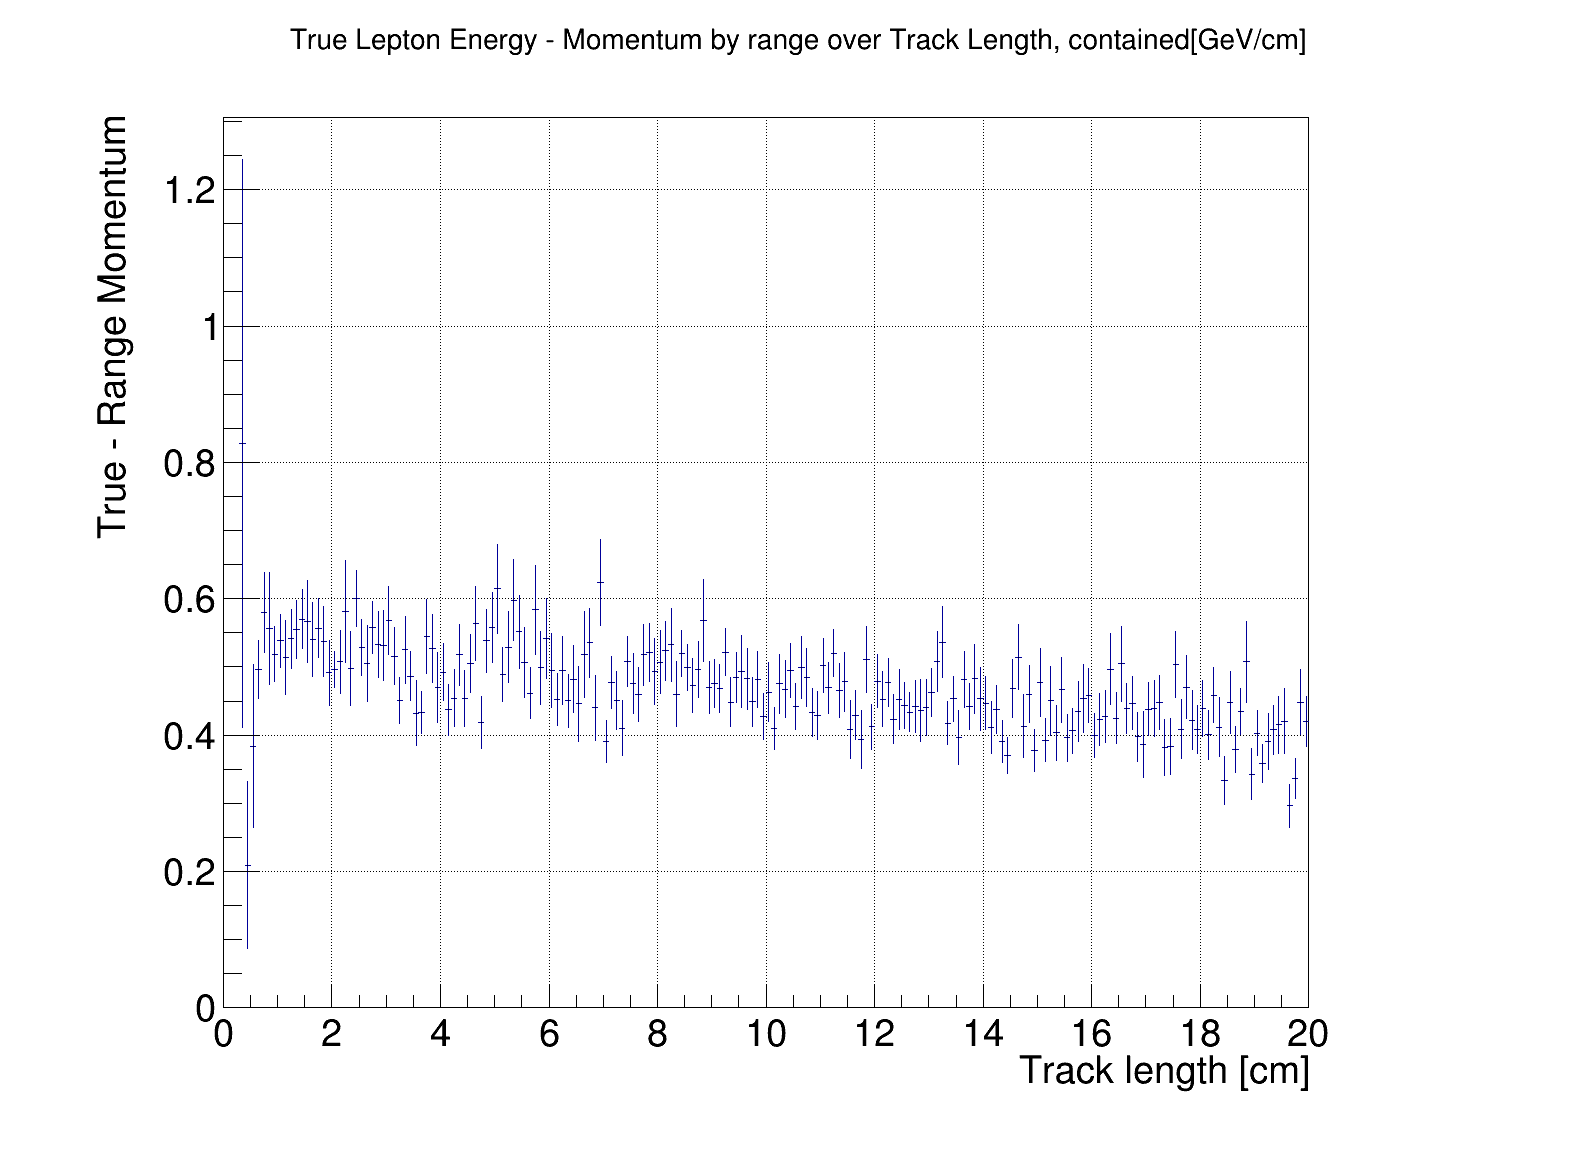

In [13]:
title = 'True Lepton Energy - Momentum by range over Track Length, contained[GeV/cm]'
h_pos = ROOT.TProfile("h_pos", title, xbin,xstart,xend)
overlay.Draw('MCNu_LeptonEnergy-TrackMomRange_mu:TrackLength>>h_pos','track_key==muon_candidate_key && TrackMomRange_mu<6 && !track_end_uncontained && fidVol','profz')
h_pos.SetXTitle("Track length [cm]")
h_pos.SetYTitle("True - Range Momentum")

h_pos.Draw('')
c1.Draw()
c1.SaveAs(outputdir_png + "h_range_contained_tracklength.png")
c1.SaveAs(outputdir_root + "h_range_contained_tracklength.root")

Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_CRTX.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_CRTX.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_MC (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_CRTY.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_CRTY.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Warnin

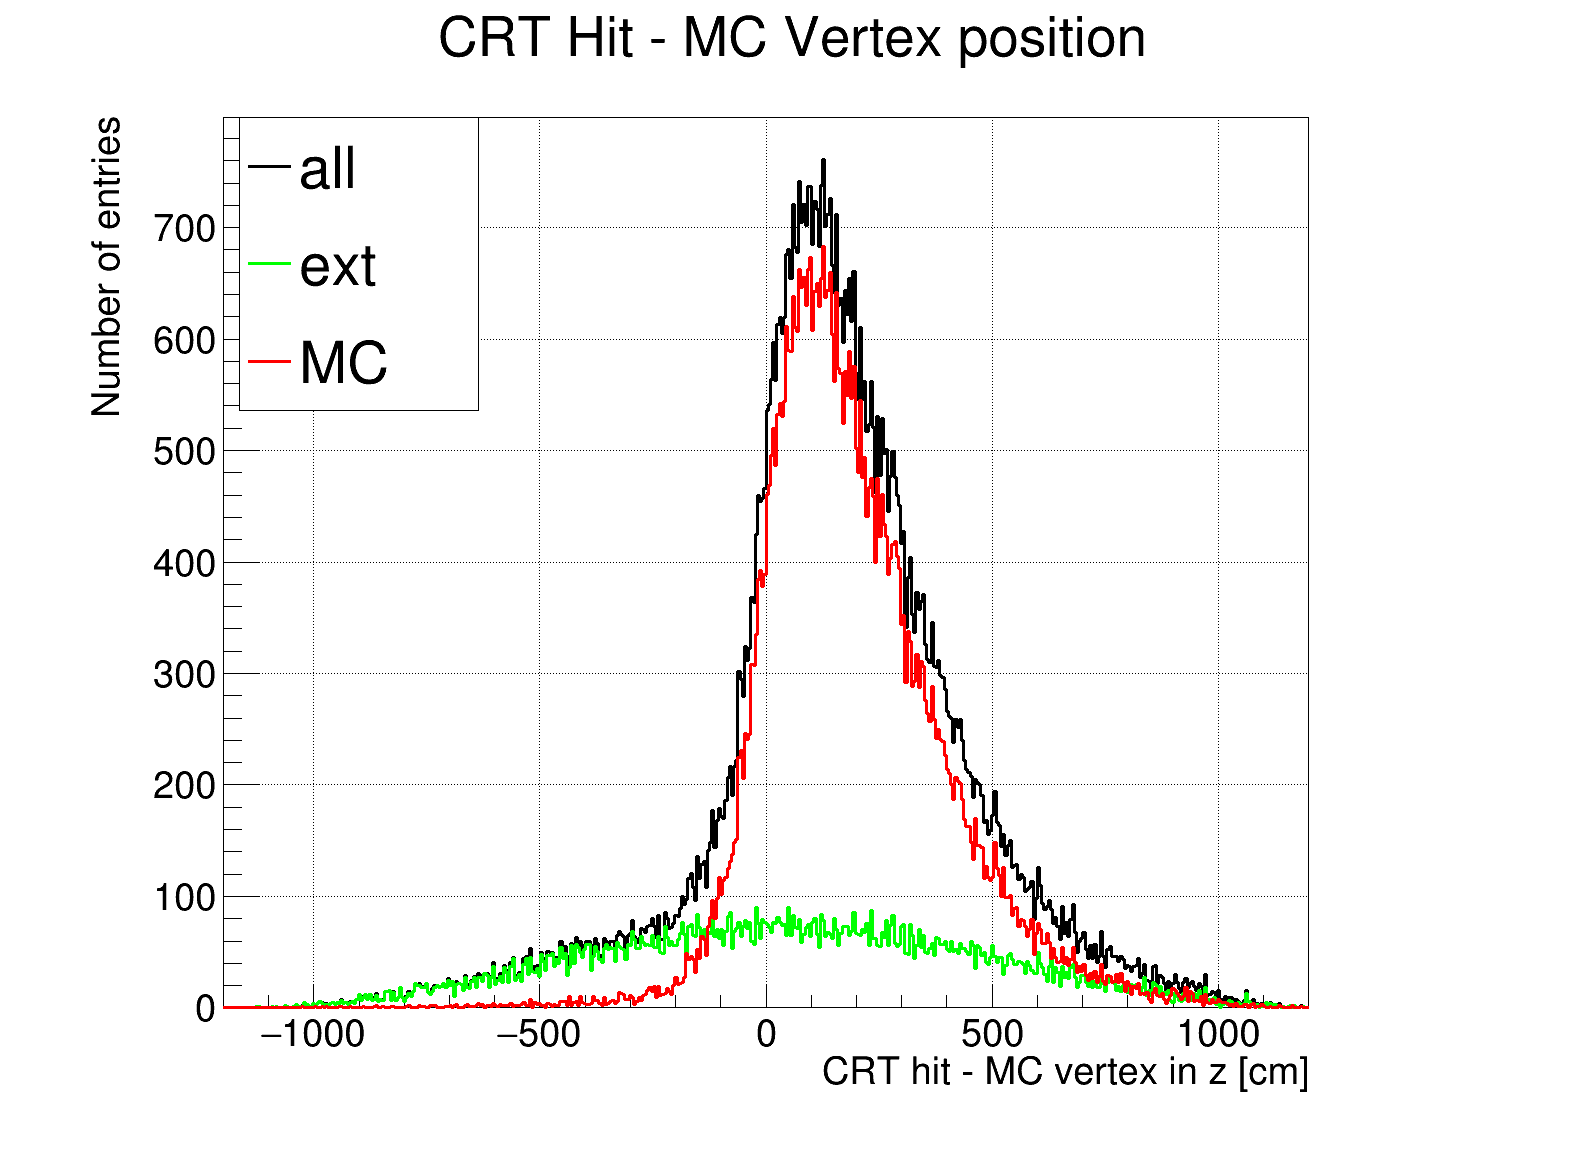

In [14]:
title = 'CRT Hit - MC Vertex position'
name = 'CRTX'
xstart = -600
xend = 600
xbin = 500
cut = 'fidVol && '
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
overlay.Draw('crthit_x-MCNu_Vx>>h_pos',cut+'1')
overlay.Draw('crthit_x-MCNu_Vx>>h_pos_ext',cut+'adc_length==32')
overlay.Draw('crthit_x-MCNu_Vx>>h_pos_MC',cut+'adc_length==2')
h_pos.SetXTitle("CRT hit - MC vertex in z [cm]")
h_pos.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos,"all","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC","l");
h_pos.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos.Draw()
h_pos_ext.Draw('same')
h_pos_MC.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

name = 'CRTY'
xstart = -1200
xend = 1200
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
overlay.Draw('crthit_y-MCNu_Vy>>h_pos',cut+'1')
overlay.Draw('crthit_y-MCNu_Vy>>h_pos_ext',cut+'adc_length==32')
overlay.Draw('crthit_y-MCNu_Vy>>h_pos_MC',cut+'adc_length==2')
h_pos.SetXTitle("CRT hit - MC vertex in y [cm]")
h_pos.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos,"all","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC","l");
h_pos.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos.Draw()
h_pos_ext.Draw('same')
h_pos_MC.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

name = 'CRTZ'
xstart = -1200
xend = 1200
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
overlay.Draw('crthit_z-MCNu_Vz>>h_pos',cut+'1')
overlay.Draw('crthit_z-MCNu_Vz>>h_pos_ext',cut+'adc_length==32')
overlay.Draw('crthit_z-MCNu_Vz>>h_pos_MC',cut+'adc_length==2')
h_pos.SetXTitle("CRT hit - MC vertex in z [cm]")
h_pos.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos,"all","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC","l");
h_pos.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos.Draw()
h_pos_ext.Draw('same')
h_pos_MC.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_MC (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_CRTY_sides.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_CRTY_sides.root has been created


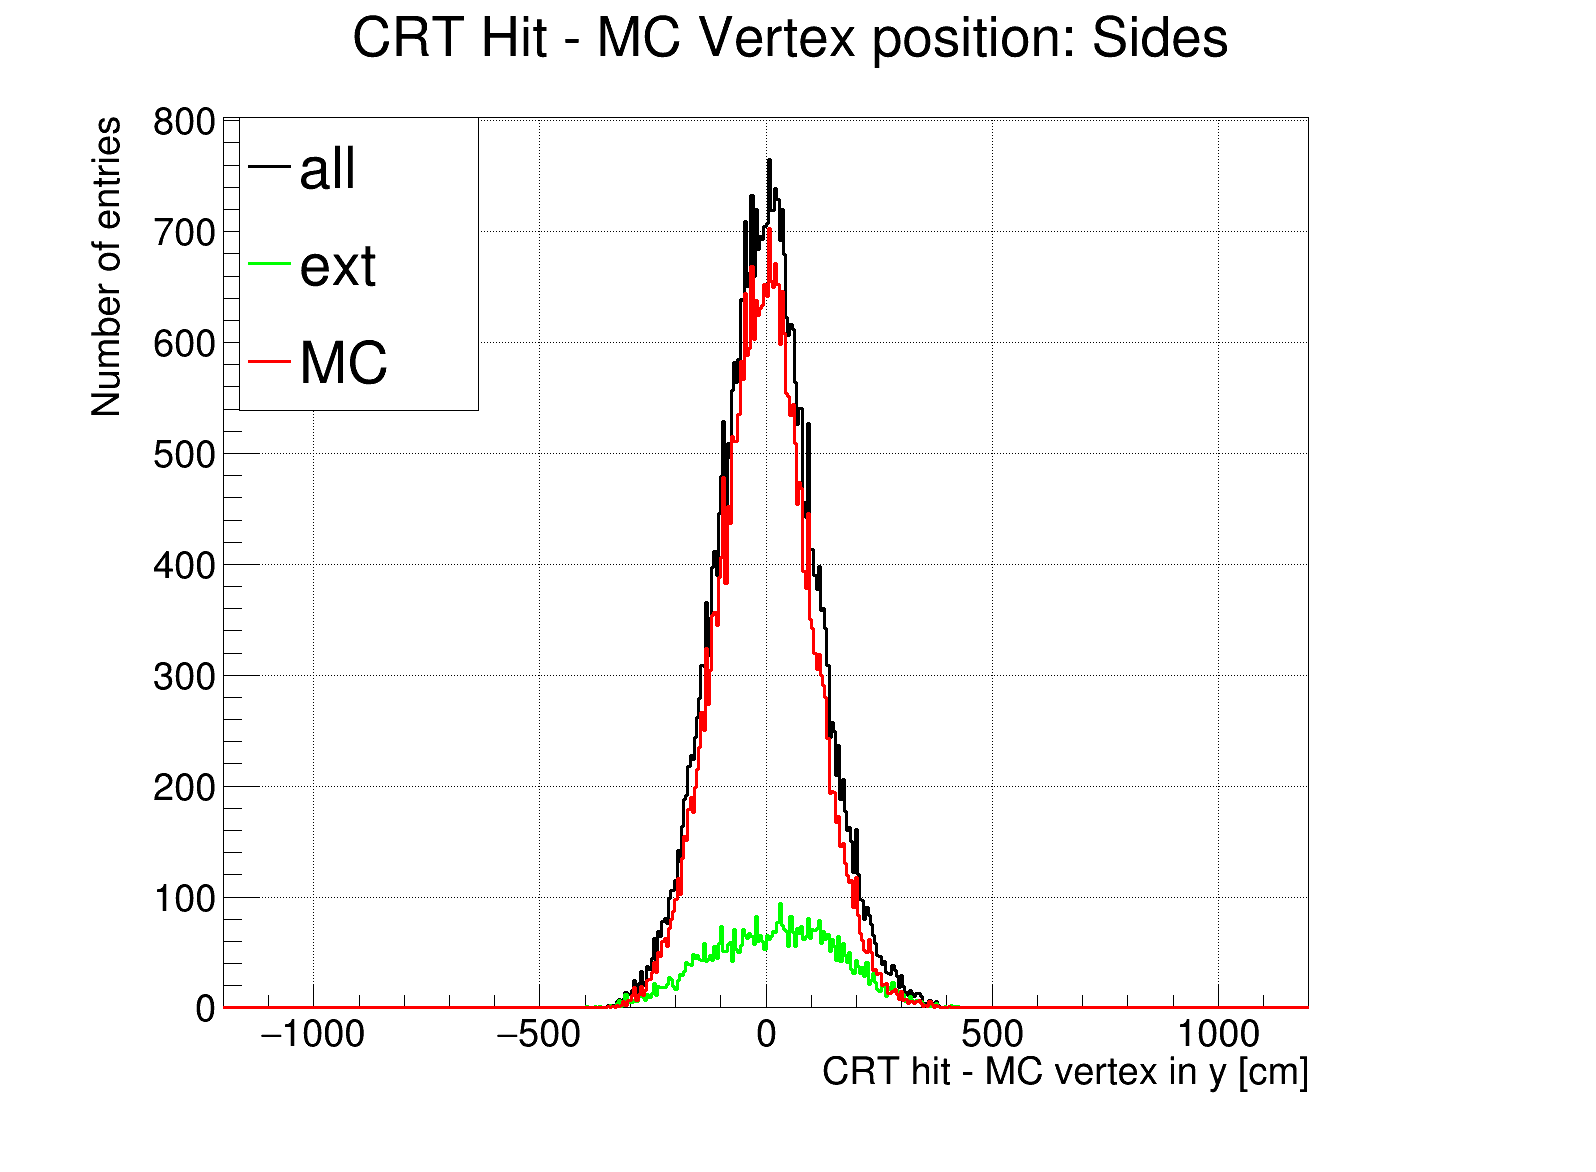

In [15]:
title = 'CRT Hit - MC Vertex position: Sides'

name = 'CRTY_sides'
xstart = -1200
xend = 1200
xbin = 500
cut = 'fidVol && (crt_plane==2 || crt_plane==1) && crt_adc>100 &&'
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
overlay.Draw('crthit_y-MCNu_Vy>>h_pos',cut+'1')
overlay.Draw('crthit_y-MCNu_Vy>>h_pos_ext',cut+'adc_length==32')
overlay.Draw('crthit_y-MCNu_Vy>>h_pos_MC',cut+'adc_length==2')
h_pos.SetXTitle("CRT hit - MC vertex in y [cm]")
h_pos.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos,"all","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC","l");
h_pos.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos.Draw()
h_pos_ext.Draw('same')
h_pos_MC.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")


Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_MC (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_CRT_plane.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_CRT_plane.root has been created


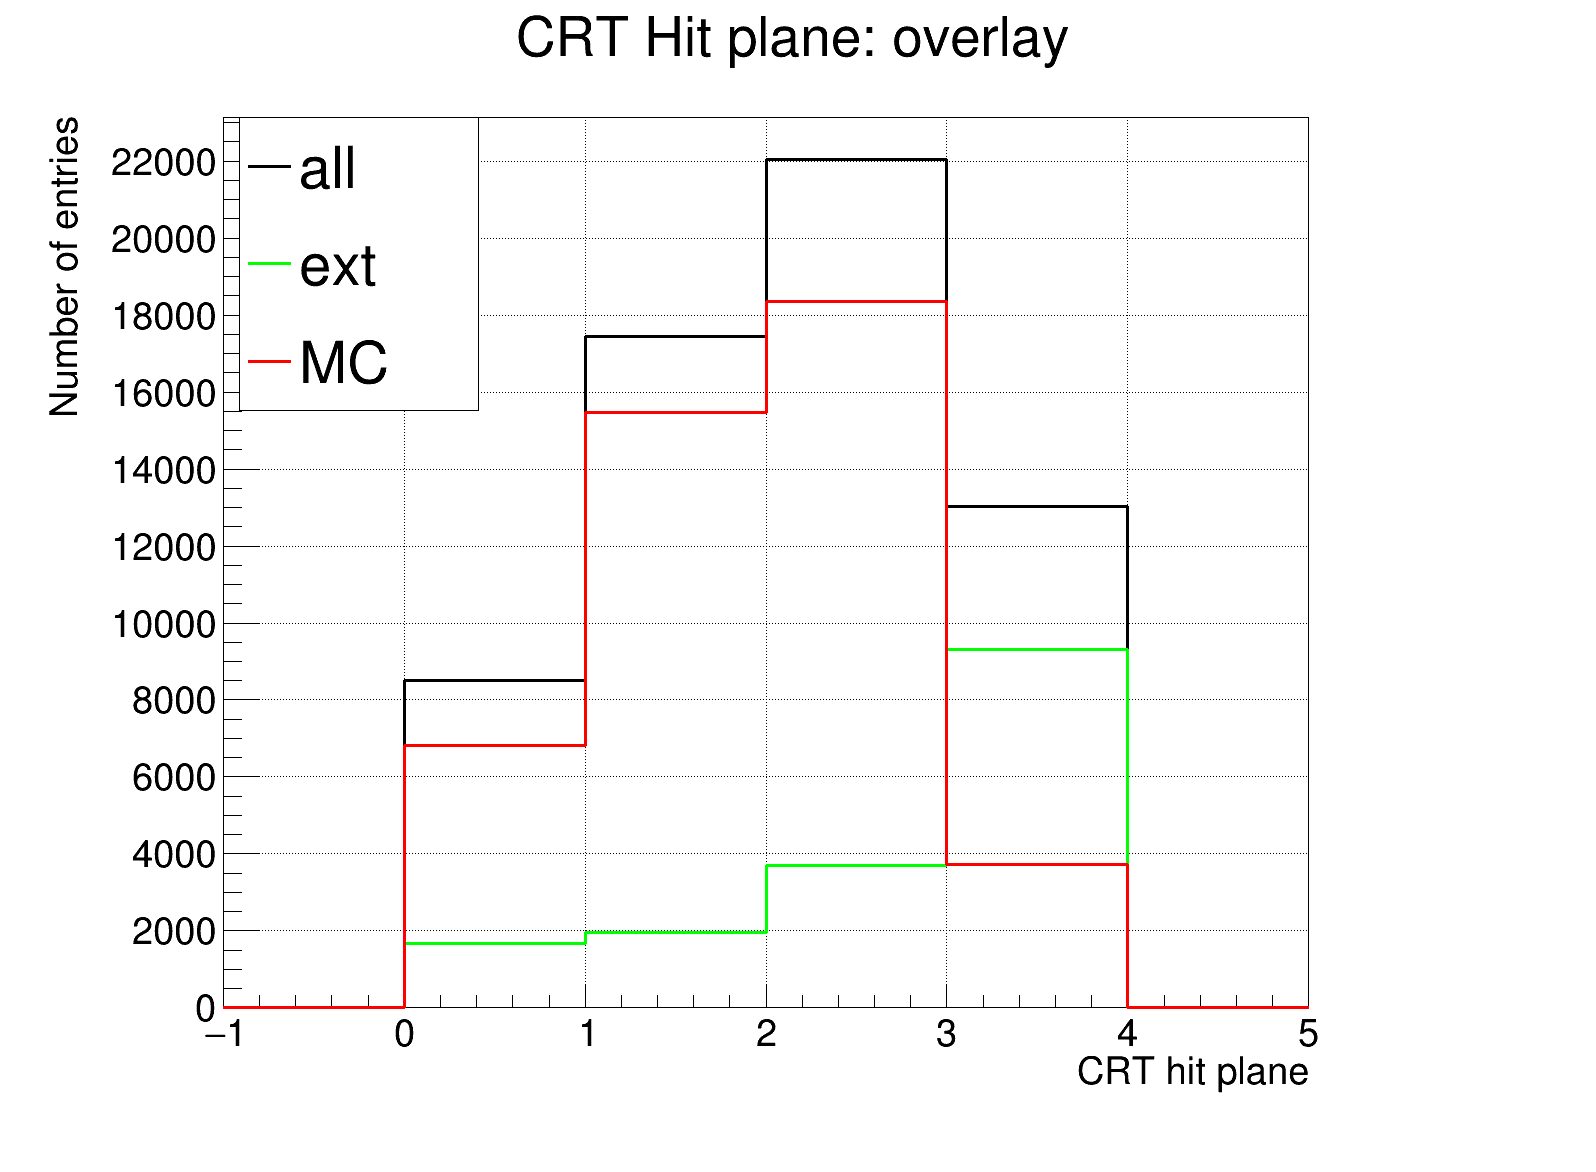

In [16]:
title = 'CRT Hit plane: overlay'

name = 'CRT_plane'
xstart = -1
xend = 5
xbin = 6
cut = 'fidVol && crt_adc>100 &&'
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
overlay.Draw('crt_plane>>h_pos',cut+'1')
overlay.Draw('crt_plane>>h_pos_ext',cut+'adc_length==32')
overlay.Draw('crt_plane>>h_pos_MC',cut+'adc_length==2')
h_pos.SetXTitle("CRT hit plane")
h_pos.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos,"all","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC","l");
h_pos.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos.Draw()
h_pos_ext.Draw('same')
h_pos_MC.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")


Warning in <TROOT::Append>: Replacing existing TH1: h_pos_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_ext (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_MC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos_dirt (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_CRT_plane_samples_contained.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_CRT_plane_samples_contained.root has been created


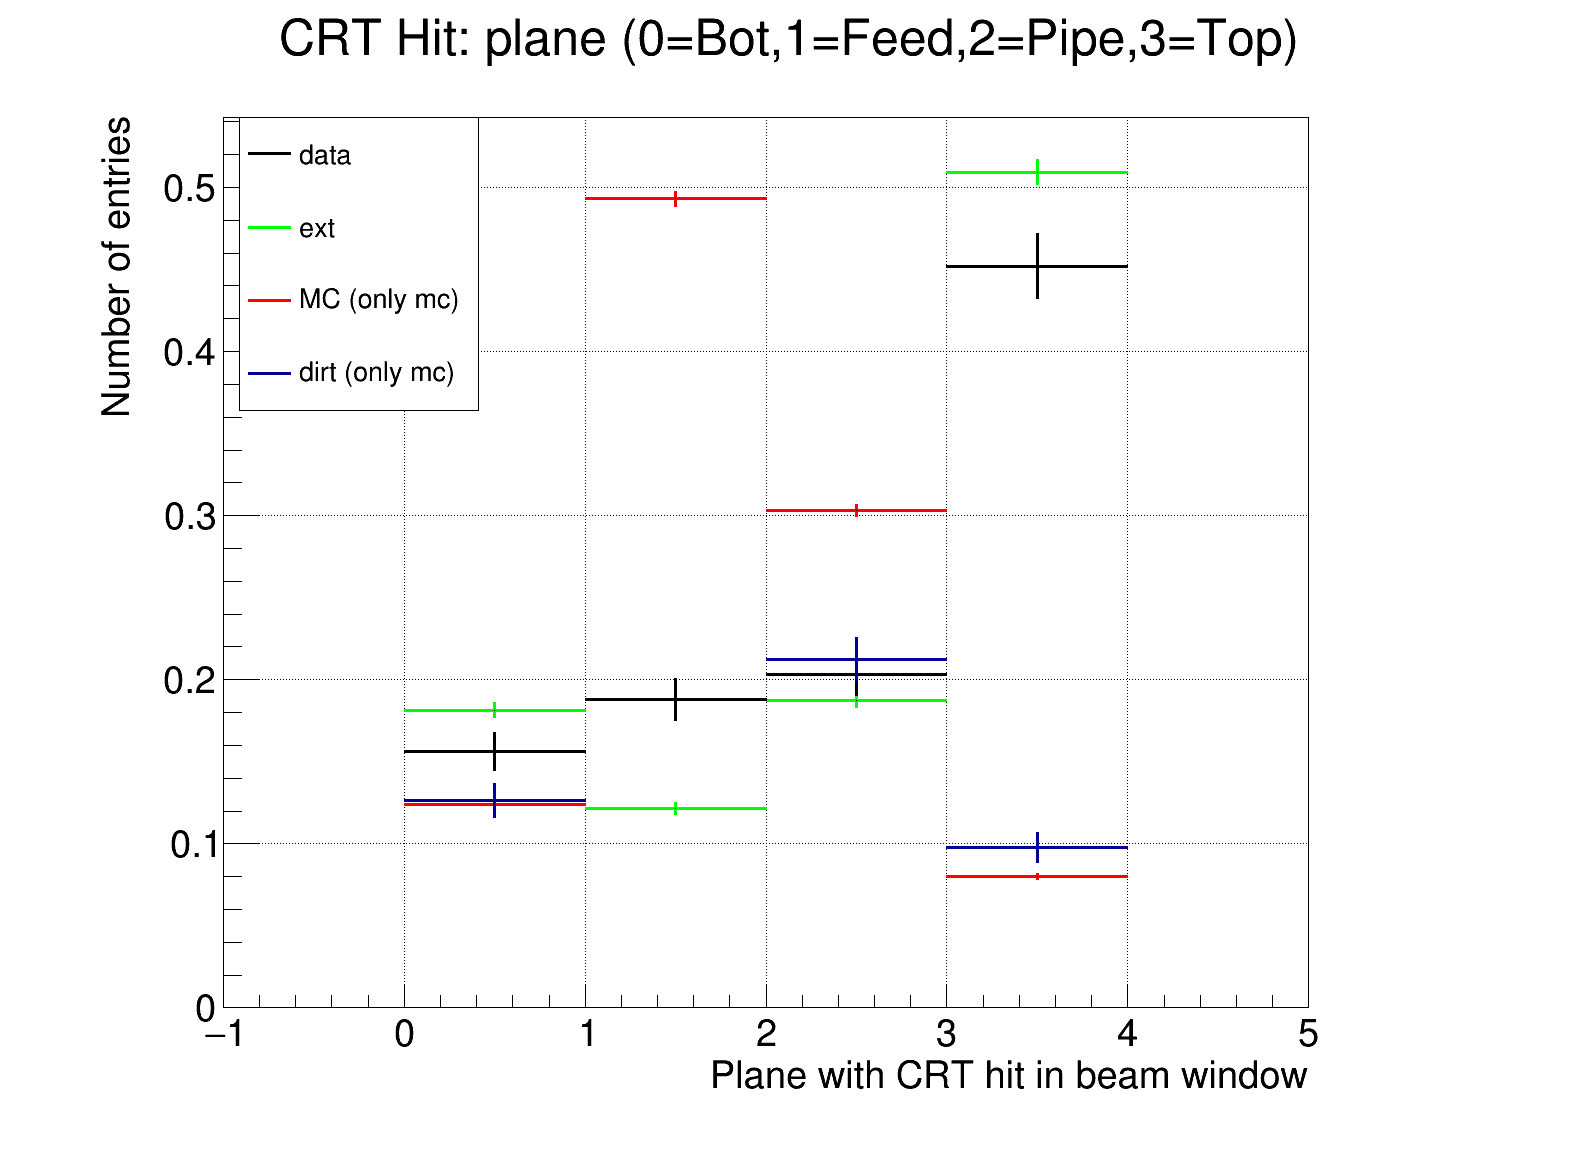

In [28]:
title = 'CRT Hit: plane (0=Bot,1=Feed,2=Pipe,3=Top)'

name = 'CRT_plane_samples_contained'
xstart = -1
xend = 5
xbin = 6
#datasample = ext
cut = 'fidVol && crt_adc>100 && !track_end_uncontained &&'
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos_data = ROOT.TH1F("h_pos_data",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
h_pos_dirt = ROOT.TH1F("h_pos_dirt",title,xbin,xstart,xend)
data.Draw('crt_plane>>h_pos_data',cut+'1')
ext.Draw('crt_plane>>h_pos_ext',cut+'1')
overlay.Draw('crt_plane>>h_pos_MC',cut+'adc_length==2')
dirt.Draw('crt_plane>>h_pos_dirt',cut+'adc_length==2')
h_pos_ext.SetXTitle("Plane with CRT hit in beam window")
h_pos_ext.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos_data,"data","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC (only mc)","l");
legend.AddEntry(h_pos_dirt,"dirt (only mc)","l");
h_pos_data.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos_data.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos_dirt.SetLineWidth(3)
#h_pos_data.Scale(1.0, "width")
h_pos_data.Scale(1.0/h_pos_data.Integral(), "width")
h_pos_ext.Scale(1.0/h_pos_ext.Integral(), "width")
h_pos_MC.Scale(1.0/h_pos_MC.Integral(), "width")
h_pos_dirt.Scale(1.0/h_pos_dirt.Integral(), "width");
h_pos_ext.Draw('')
h_pos_data.Draw('same')
h_pos_MC.Draw('same')
h_pos_dirt.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_CRTY_sides_sample.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_CRTY_sides_sample.root has been created


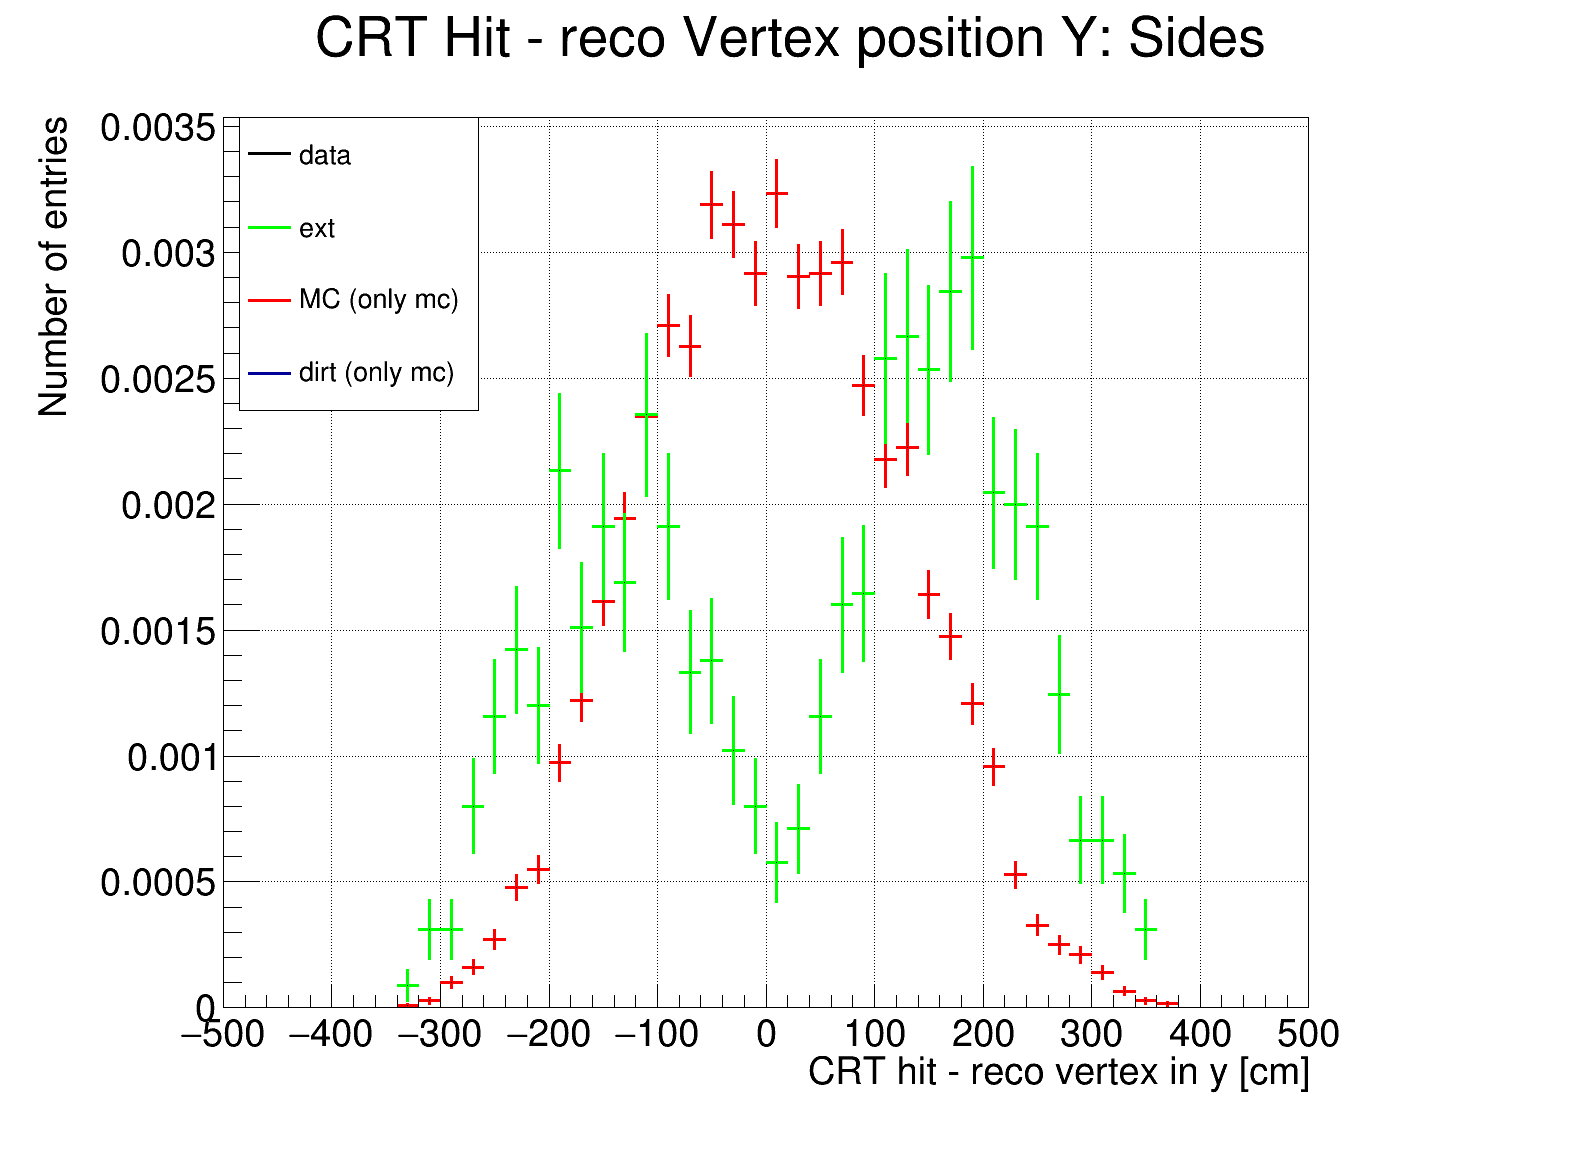

In [11]:
title = 'CRT Hit - reco Vertex position Y: Sides'

name = 'CRTY_sides_sample'
xstart = -500
xend = 500
xbin = 50
cut = 'fidVol && (crt_plane==2 || crt_plane==1) && crt_adc>100 && track_end_uncontained &&'
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos_data = ROOT.TH1F("h_pos_data",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
h_pos_dirt = ROOT.TH1F("h_pos_dirt",title,xbin,xstart,xend)
data.Draw('crthit_y-Nu_Vy_sce>>h_pos_data',cut+'1')
ext.Draw('crthit_y-Nu_Vy_sce>>h_pos_ext',cut+'1')
overlay.Draw('crthit_y-Nu_Vy_sce>>h_pos_MC',cut+'adc_length==2')
dirt.Draw('crthit_y-Nu_Vy_sce>>h_pos_dirt',cut+'adc_length==2')
h_pos_MC.SetXTitle("CRT hit - reco vertex in y [cm]")
h_pos_MC.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos_data,"data","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC (only mc)","l");
legend.AddEntry(h_pos_dirt,"dirt (only mc)","l");
h_pos_data.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos_data.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos_dirt.SetLineWidth(3)
#h_pos_data.Scale(1.0, "width")
h_pos_data.Scale(1.0/h_pos_data.Integral(), "width")
h_pos_ext.Scale(1.0/h_pos_ext.Integral(), "width")
h_pos_MC.Scale(1.0/h_pos_MC.Integral(), "width")
h_pos_dirt.Scale(1.0/h_pos_dirt.Integral(), "width");
h_pos_MC.Draw('')
#h_pos_data.Draw('same')
h_pos_ext.Draw('same')
#h_pos_dirt.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

muon && fidVol && TrackLength>8 && (crthit_y==-9999 || (crthit_y<300 && crthit_y>-240 && abs(crthit_y-Nu_Vy_sce)<(5.0*0)))
57.9178313993 45.0675223732 2610.2131624 0
muon && fidVol && TrackLength>8 && (crthit_y==-9999 || (crthit_y<300 && crthit_y>-240 && abs(crthit_y-Nu_Vy_sce)<(5.0*1)))
58.1202252876 45.052867175 2618.48279006 1
muon && fidVol && TrackLength>8 && (crthit_y==-9999 || (crthit_y<300 && crthit_y>-240 && abs(crthit_y-Nu_Vy_sce)<(5.0*2)))
58.3429415131 45.0565398008 2628.73106638 2
muon && fidVol && TrackLength>8 && (crthit_y==-9999 || (crthit_y<300 && crthit_y>-240 && abs(crthit_y-Nu_Vy_sce)<(5.0*3)))
58.5449206599 45.0367864708 2636.67509071 3
muon && fidVol && TrackLength>8 && (crthit_y==-9999 || (crthit_y<300 && crthit_y>-240 && abs(crthit_y-Nu_Vy_sce)<(5.0*4)))
58.7564388629 45.0234128565 2645.4154049 4
muon && fidVol && TrackLength>8 && (crthit_y==-9999 || (crthit_y<300 && crthit_y>-240 && abs(crthit_y-Nu_Vy_sce)<(5.0*5)))
58.9770813806 45.0010324721 2654.02955432 5
m

Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/abs(crthit_y-Nu_Vy_sce).png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/abs(crthit_y-Nu_Vy_sce).root has been created


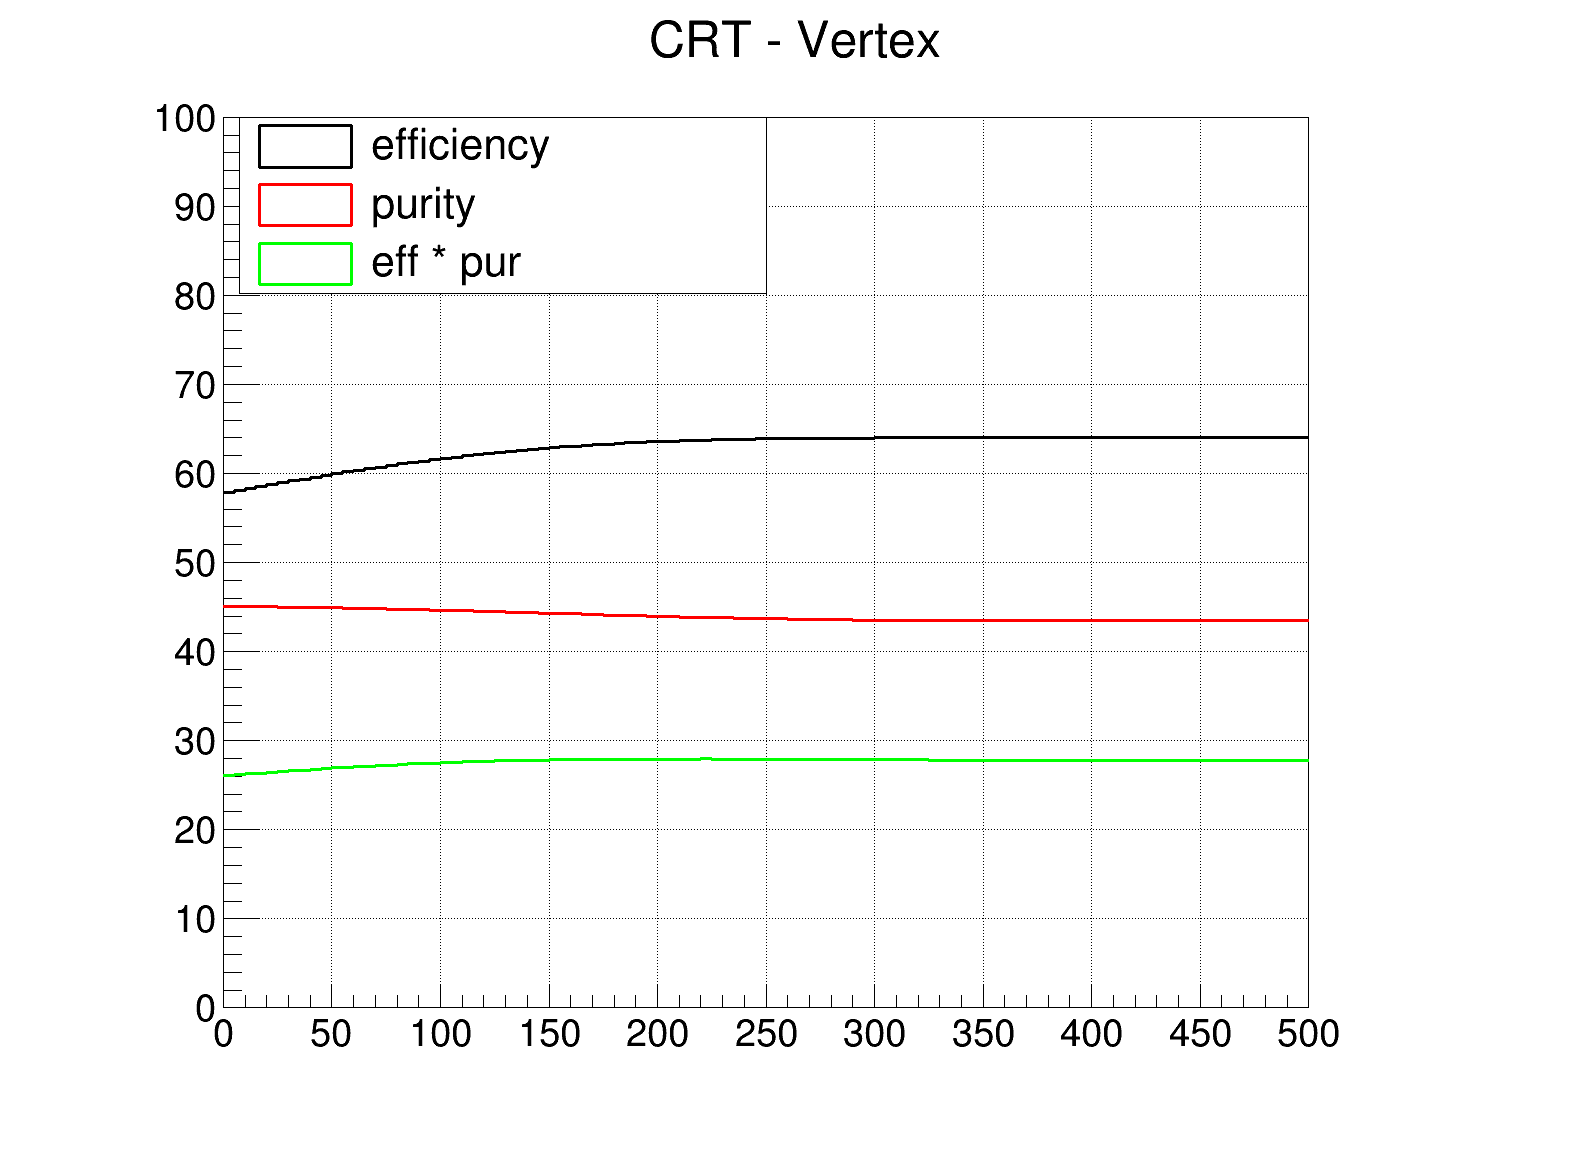

In [20]:
value = 'abs(crthit_y-Nu_Vy_sce)'
xbins = 100
xstart = 0
xend = 500.0
step = 500/xbins
title = 'CRT - Vertex'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)

for i in range(xbins): 
    cut = 'muon && fidVol && TrackLength>8 && (crthit_y==-9999 || (crthit_y<300 && crthit_y>-240 && '+value+'<('+str(step)+'*'+str(i)+')))'
    print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_pos_CRTZ_sample.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_pos_CRTZ_sample.root has been created


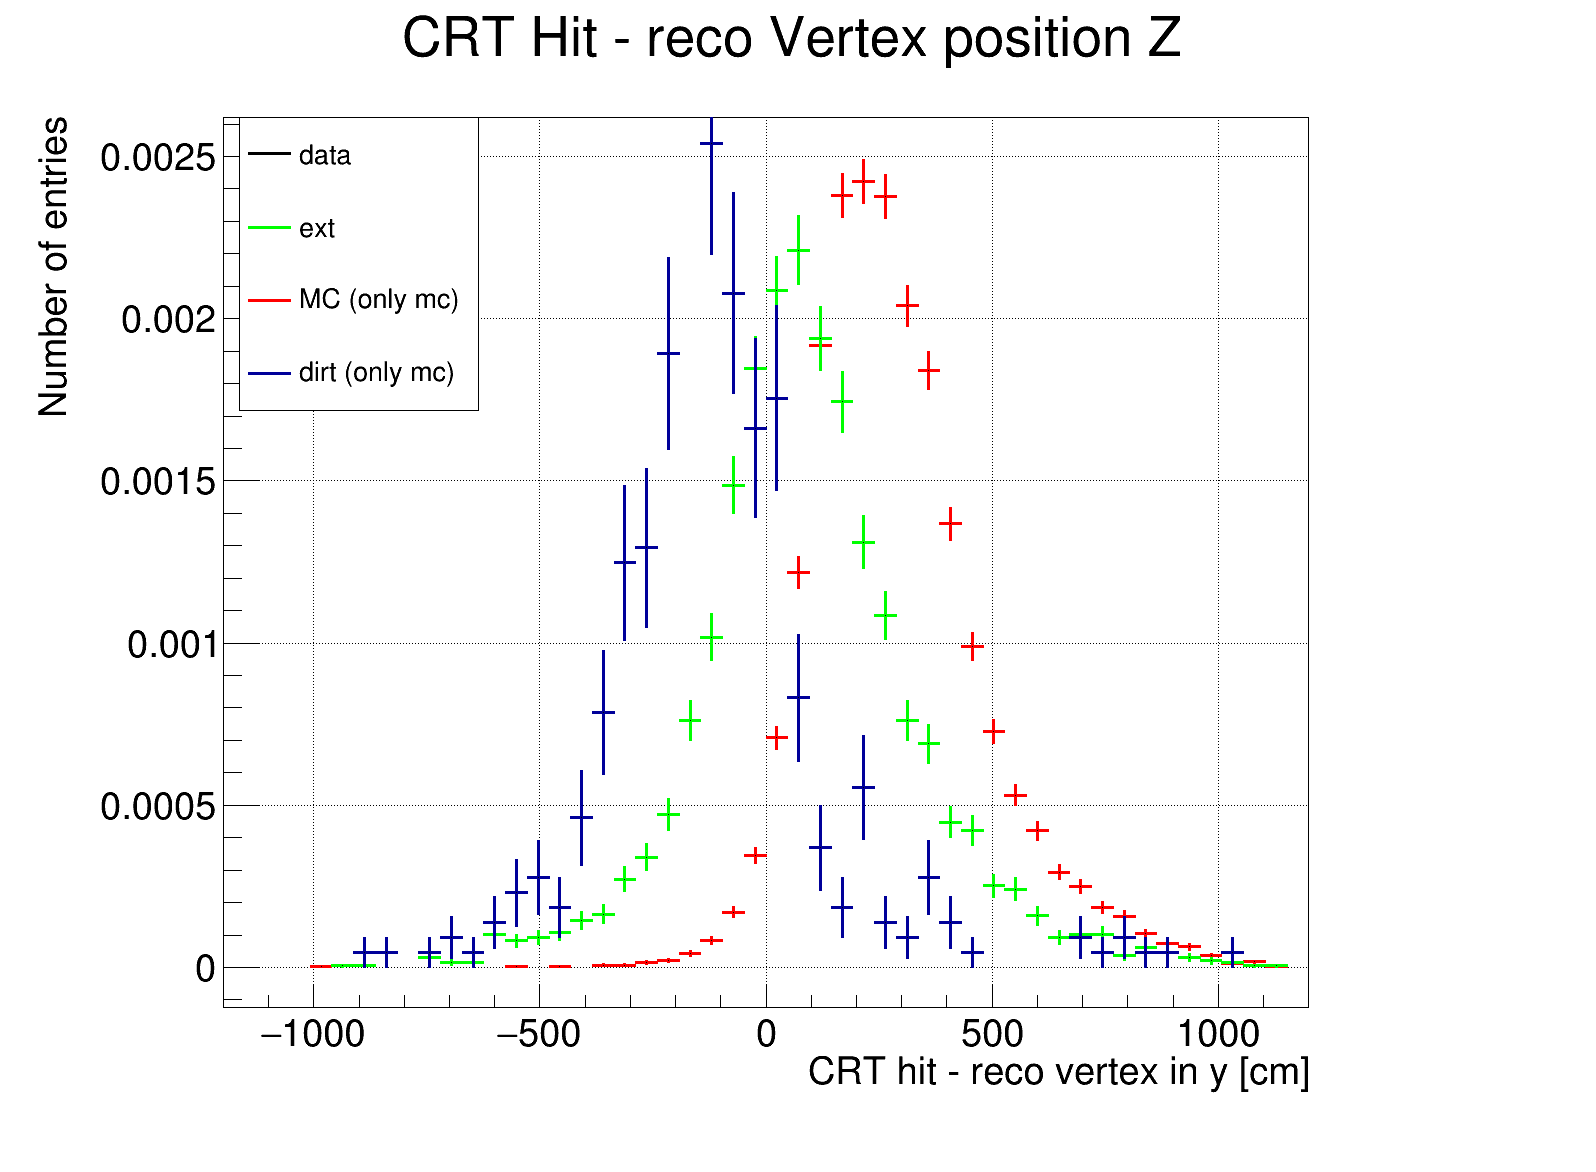

In [14]:
title = 'CRT Hit - reco Vertex position Z'

name = 'CRTZ_sample'
xstart = -1200
xend = 1200
xbin = 50
cut = 'fidVol && crt_adc>100 && track_end_uncontained &&'
variable = 'crthit_z-Nu_Vz_sce'
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
h_pos_data = ROOT.TH1F("h_pos_data",title,xbin,xstart,xend)
h_pos_ext = ROOT.TH1F("h_pos_ext",title,xbin,xstart,xend)
h_pos_MC = ROOT.TH1F("h_pos_MC",title,xbin,xstart,xend)
h_pos_dirt = ROOT.TH1F("h_pos_dirt",title,xbin,xstart,xend)
data.Draw(variable+'>>h_pos_data',cut+'1')
ext.Draw(variable+'>>h_pos_ext',cut+'1')
overlay.Draw(variable+'>>h_pos_MC',cut+'adc_length==2 && numu_true')
dirt.Draw(variable+'>>h_pos_dirt',cut+'adc_length==2')
h_pos_MC.SetXTitle("CRT hit - reco vertex in y [cm]")
h_pos_MC.SetYTitle("Number of entries")
legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
legend.AddEntry(h_pos_data,"data","l");
legend.AddEntry(h_pos_ext,"ext","l");
legend.AddEntry(h_pos_MC,"MC (only mc)","l");
legend.AddEntry(h_pos_dirt,"dirt (only mc)","l");
h_pos_data.SetLineColor(1)
h_pos_ext.SetLineColor(3)
h_pos_MC.SetLineColor(2)
h_pos_data.SetLineWidth(3)
h_pos_ext.SetLineWidth(3)
h_pos_MC.SetLineWidth(3)
h_pos_dirt.SetLineWidth(3)
#h_pos_data.Scale(1.0, "width")
h_pos_data.Scale(1.0/h_pos_data.Integral(), "width")
h_pos_ext.Scale(1.0/h_pos_ext.Integral(), "width")
h_pos_MC.Scale(1.0/h_pos_MC.Integral(), "width")
h_pos_dirt.Scale(1.0/h_pos_dirt.Integral(), "width");
h_pos_MC.Draw('')
#h_pos_data.Draw('same')
h_pos_ext.Draw('same')
h_pos_dirt.Draw('same')
legend.Draw('same');
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

66.4863923289 38.9047471314 2586.63628124 0
66.4797564637 38.9156549968 2587.10326682 1
66.4718763738 38.9230451517 2587.28784542 2
66.4639962839 38.9277000397 2587.29051078 3
66.4565309356 38.9375083368 2587.65172734 4
66.4486508457 38.9485411402 2588.07801118 5
66.4428444636 38.9627206393 2588.79398732 6
66.4370380816 38.970821415 2589.10594642 7
66.4312316995 38.9801949936 2589.50236531 8
66.420033677 38.9929833039 2589.91526421 9
66.4117388455 39.0012365177 2590.13993426 10
66.4055177219 39.0152827765 2590.83005184 11
66.3963934073 39.0310636226 2591.52185539 12
66.3880985758 39.0392645864 2591.74254569 13
66.3798037443 39.0621067999 2592.93498322 14
66.3686057218 39.0842017275 2593.9639744 15
66.3603108903 39.101190243 2594.76714071 16
66.3507718341 39.1300620554 2596.30981929 17
66.342062261 39.1548187737 2597.61142491 18
66.3308642385 39.1801460014 2598.85294526 19
66.3209104407 39.2067058969 2600.22443046 20
66.3047355193 39.2429954488 2601.99643422 21
66.2976849125 39.28259233

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/(crthit_z - Nu_Vz_sce)trklen.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/(crthit_z - Nu_Vz_sce)trklen.root has been created


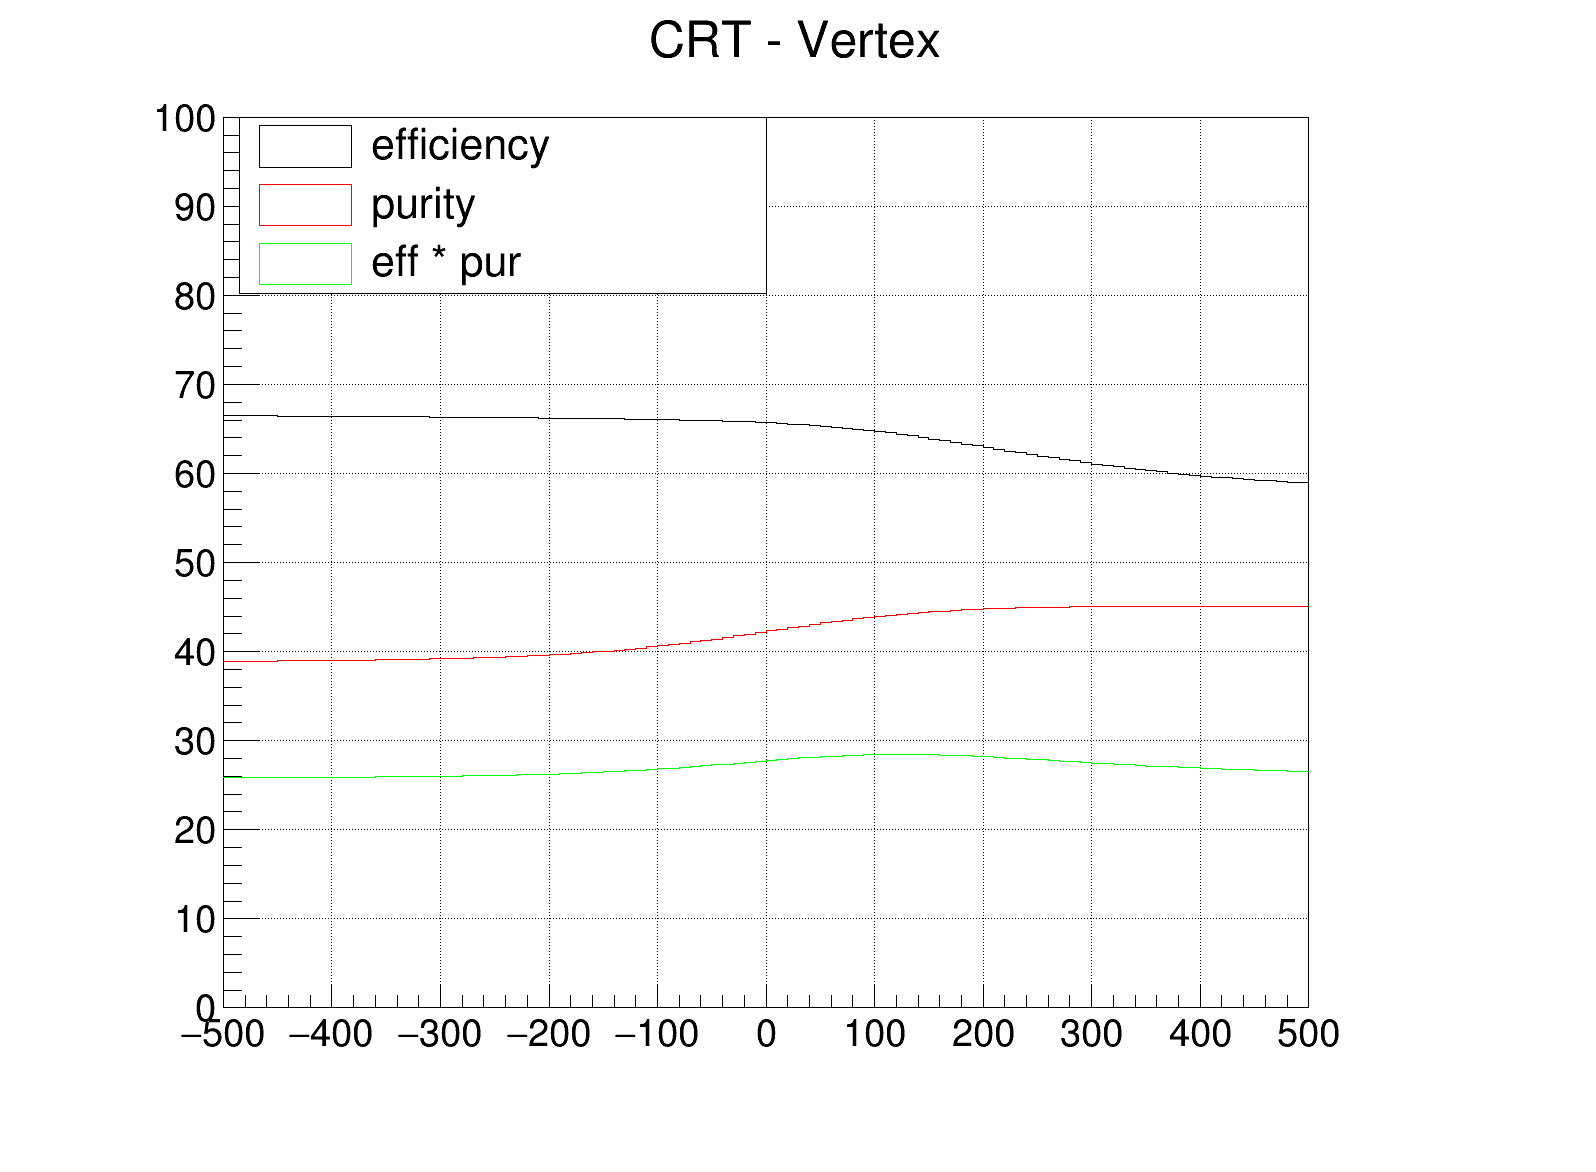

In [11]:
value = '(crthit_z - Nu_Vz_sce)'
xbins = 100
xstart = -500.0
xend = 500.0
step = (xend - xstart)/xbins
title = 'CRT - Vertex'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)

for i in range(xbins): 
    cut = 'muon && fidVol && TrackLength>8 && ( crthit_z==9999 || '+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.Draw()
c1.SaveAs(outputdir_png+ value +"trklen.png");
c1.SaveAs(outputdir_root+ value+ "trklen.root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

64.6395480976 43.3673341843 2803.24488387 0
64.6354006818 43.3742507305 2803.51207524 1
64.6295942998 43.3777736354 2803.48791168 2
64.6258616256 43.3781420875 2803.34980812 3
64.6217142099 43.3823414313 2803.44126973 4
64.6183962773 43.3866088174 2803.57308169 5
64.6150783447 43.3945373187 2803.94142858 6
64.6105161874 43.3975723232 2803.93954908 7
64.6080277379 43.4026502946 2804.15963413 8
64.6034655806 43.4107325057 2804.48376326 9
64.6018066143 43.4131230423 2804.5661793 10
64.5997329064 43.4214167743 2805.01192604 11
64.5947560075 43.426825768 2805.14521467 12
64.5930970412 43.4316166868 2805.38263131 13
64.5885348839 43.4389350922 2805.65717452 14
64.5823137603 43.4488188547 2806.02525179 15
64.5794105693 43.4589041979 2806.55041709 16
64.5744336704 43.4734723677 2807.27485783 17
64.5698715131 43.4842062382 2807.76960965 18
64.5644798726 43.4960274599 2808.29838947 19
64.5595029737 43.5065346953 2808.76025603 20
64.5512081422 43.5231620833 2809.47269465 21
64.5478902096 43.54051

Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/(crthit_z - Nu_Vz_sce)crtcont.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/(crthit_z - Nu_Vz_sce)crtcont.root has been created


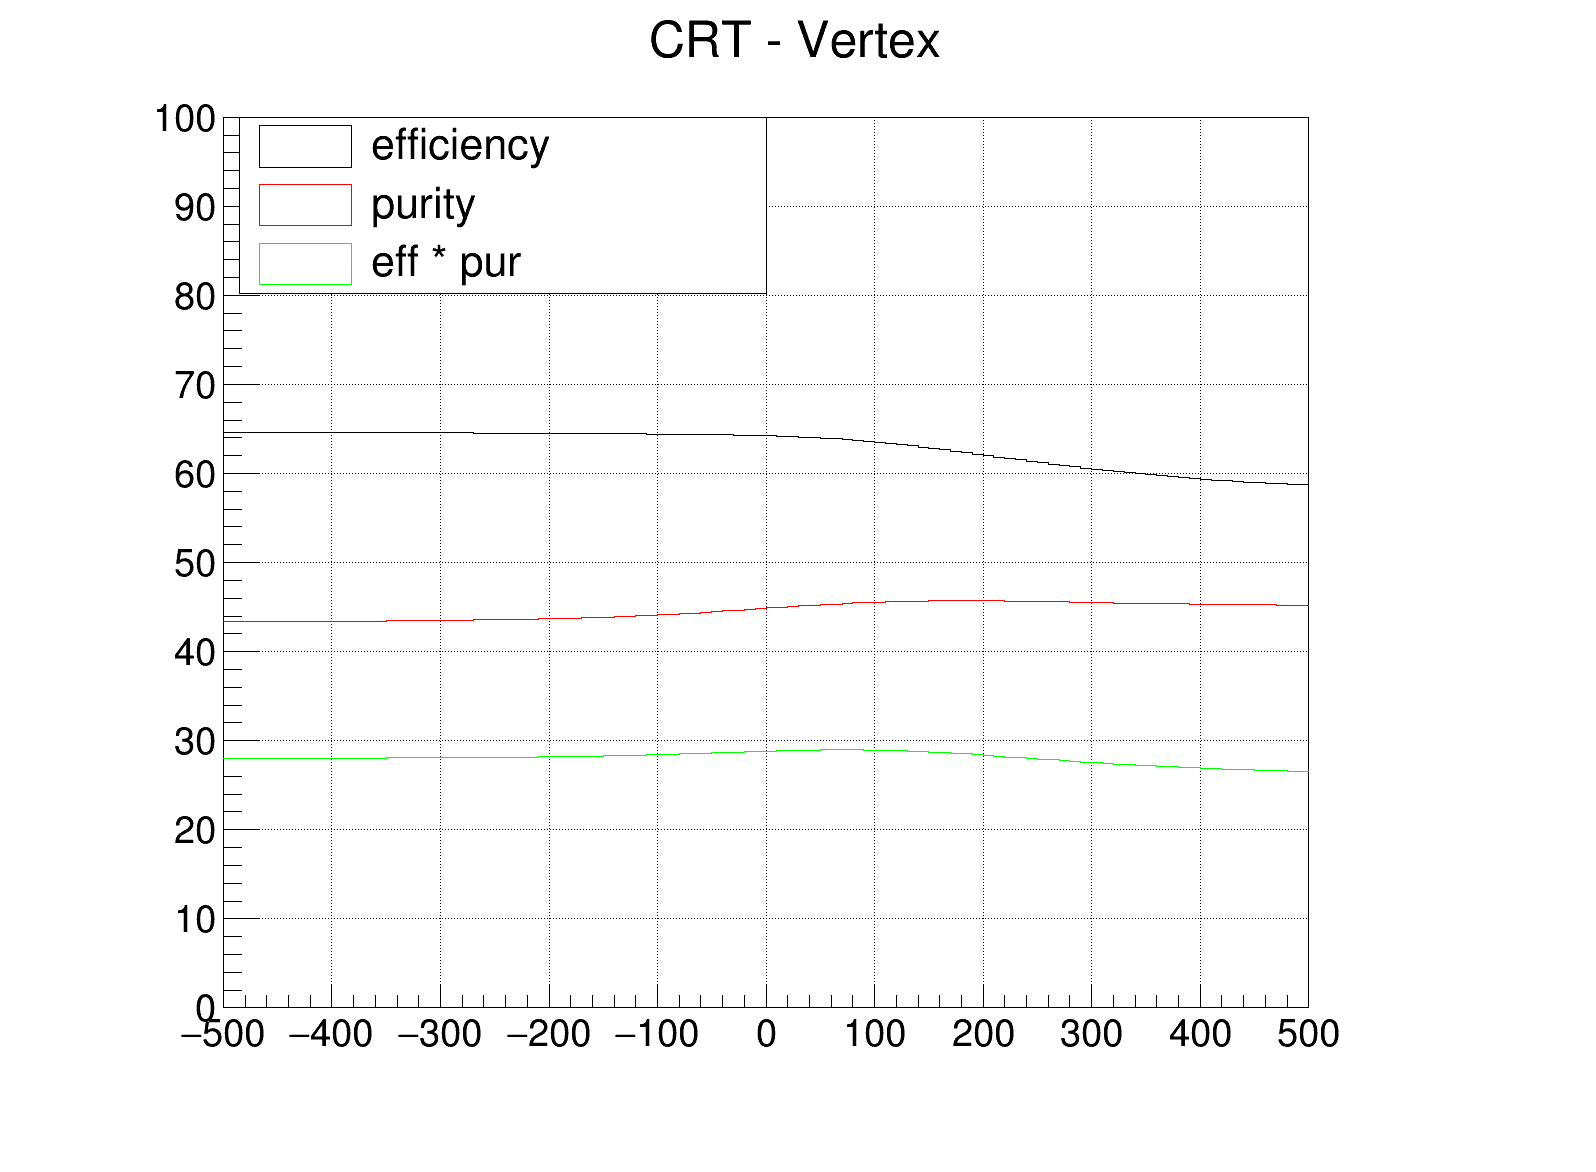

In [12]:
value = '(crthit_z - Nu_Vz_sce)'
xbins = 100
xstart = -500.0
xend = 500.0
step = (xend - xstart)/xbins
title = 'CRT - Vertex'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)

for i in range(xbins): 
    cut = 'muon && fidVol && TrackLength>8 && (track_uncontained==1 || nr_crthit_beam_tres==0) && ( crthit_z==9999 || '+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.Draw()
c1.SaveAs(outputdir_png+ value +"crtcont.png");
c1.SaveAs(outputdir_root+ value+ "crtcont.root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

63.834949443 45.2224174878 2886.77073402 0
63.8337052183 45.2241745315 2886.82662578 1
63.8324609936 45.226603942 2886.925432 2
63.8316315104 45.2282489203 2886.99291894 3
63.8312167688 45.2286272879 2886.99831257 4
63.8295578025 45.2292782567 2886.96483085 5
63.8270693531 45.2293835341 2886.85899963 6
63.8254103868 45.2303578581 2886.84615223 7
63.8241661621 45.2321159364 2886.90208339 8
63.8237514205 45.2335734362 2886.97634685 9
63.8229219373 45.2350030355 2887.03006757 10
63.8225071958 45.2392756334 2887.28399465 11
63.821262971 45.243409891 2887.49156036 12
63.8204334879 45.2477481482 2887.73090117 13
63.8200187463 45.2502790184 2887.87365523 14
63.8179450384 45.2555807608 2888.11816568 15
63.8167008137 45.2585549217 2888.2516587 16
63.8146271059 45.2681993332 2888.7732602 17
63.8129681396 45.2720457168 2888.94361094 18
63.8113091733 45.2801608454 2889.38634312 19
63.809650207 45.2865232525 2889.71720783 20
63.8067470159 45.2946601236 2890.10491968 21
63.8055027912 45.3037117593 2

Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/(crthit_z - Nu_Vz_sce)crttop.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/(crthit_z - Nu_Vz_sce)crttop.root has been created


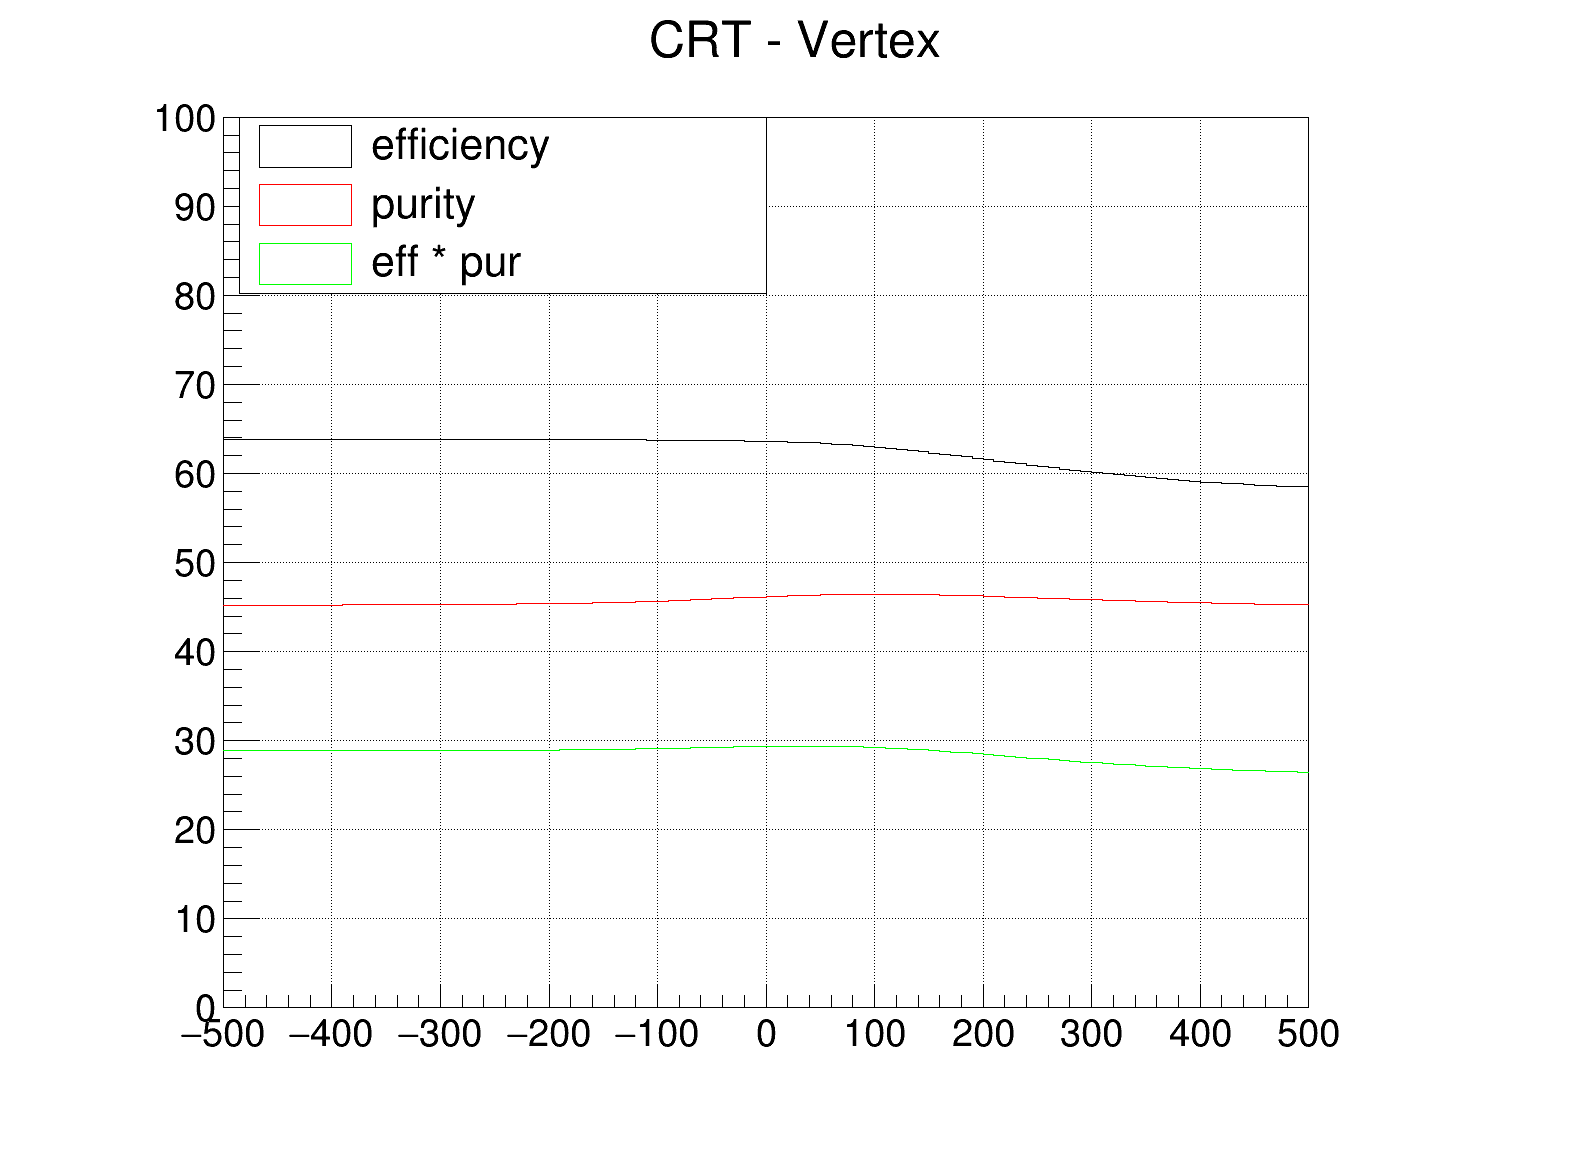

In [13]:
value = '(crthit_z - Nu_Vz_sce)'
xbins = 100
xstart = -500.0
xend = 500.0
step = (xend - xstart)/xbins
title = 'CRT - Vertex'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)

for i in range(xbins): 
    cut = 'muon && fidVol && TrackLength>8 && (track_uncontained==1 || nr_crthit_beam_tres==0) && nr_crthit_top==0 && ( crthit_z==9999 || '+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.Draw()
c1.SaveAs(outputdir_png+ value +"crttop.png");
c1.SaveAs(outputdir_root+ value+ "crttop.root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

61.5260830976 48.661777242 2993.96855027 0
61.5248388729 48.6639629194 2994.04247753 1
61.5235946482 48.6657204147 2994.09005605 2
61.522765165 48.6675867955 2994.16451357 3
61.5223504235 48.6680662874 2994.17382857 4
61.5206914572 48.6689481208 2994.14734088 5
61.5182030077 48.6692243141 2994.04322158 6
61.5165440414 48.6698466148 2994.00076277 7
61.5152998167 48.6718738022 2994.06490958 8
61.5148850751 48.6723534657 2994.07422978 9
61.514055592 48.6741207237 2994.14256809 10
61.5136408504 48.6786300883 2994.39976834 11
61.5123966257 48.6836714597 2994.64930803 12
61.5115671425 48.6881246785 2994.8828502 13
61.5111524009 48.6910301688 2995.04137727 14
61.5090786931 48.6968753745 2995.29993952 15
61.5078344683 48.6992852543 2995.38757615 16
61.5057607605 48.7083590861 2995.84468099 17
61.5041017942 48.7130793785 2996.0541928 18
61.5028575694 48.7227761649 2996.58996286 19
61.5011986032 48.7291195956 2996.899262 20
61.4982954121 48.7378292051 2997.2934182 21
61.4970511874 48.7478070969 

Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/(crthit_z - Nu_Vz_sce)crtcut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/(crthit_z - Nu_Vz_sce)crtcut.root has been created


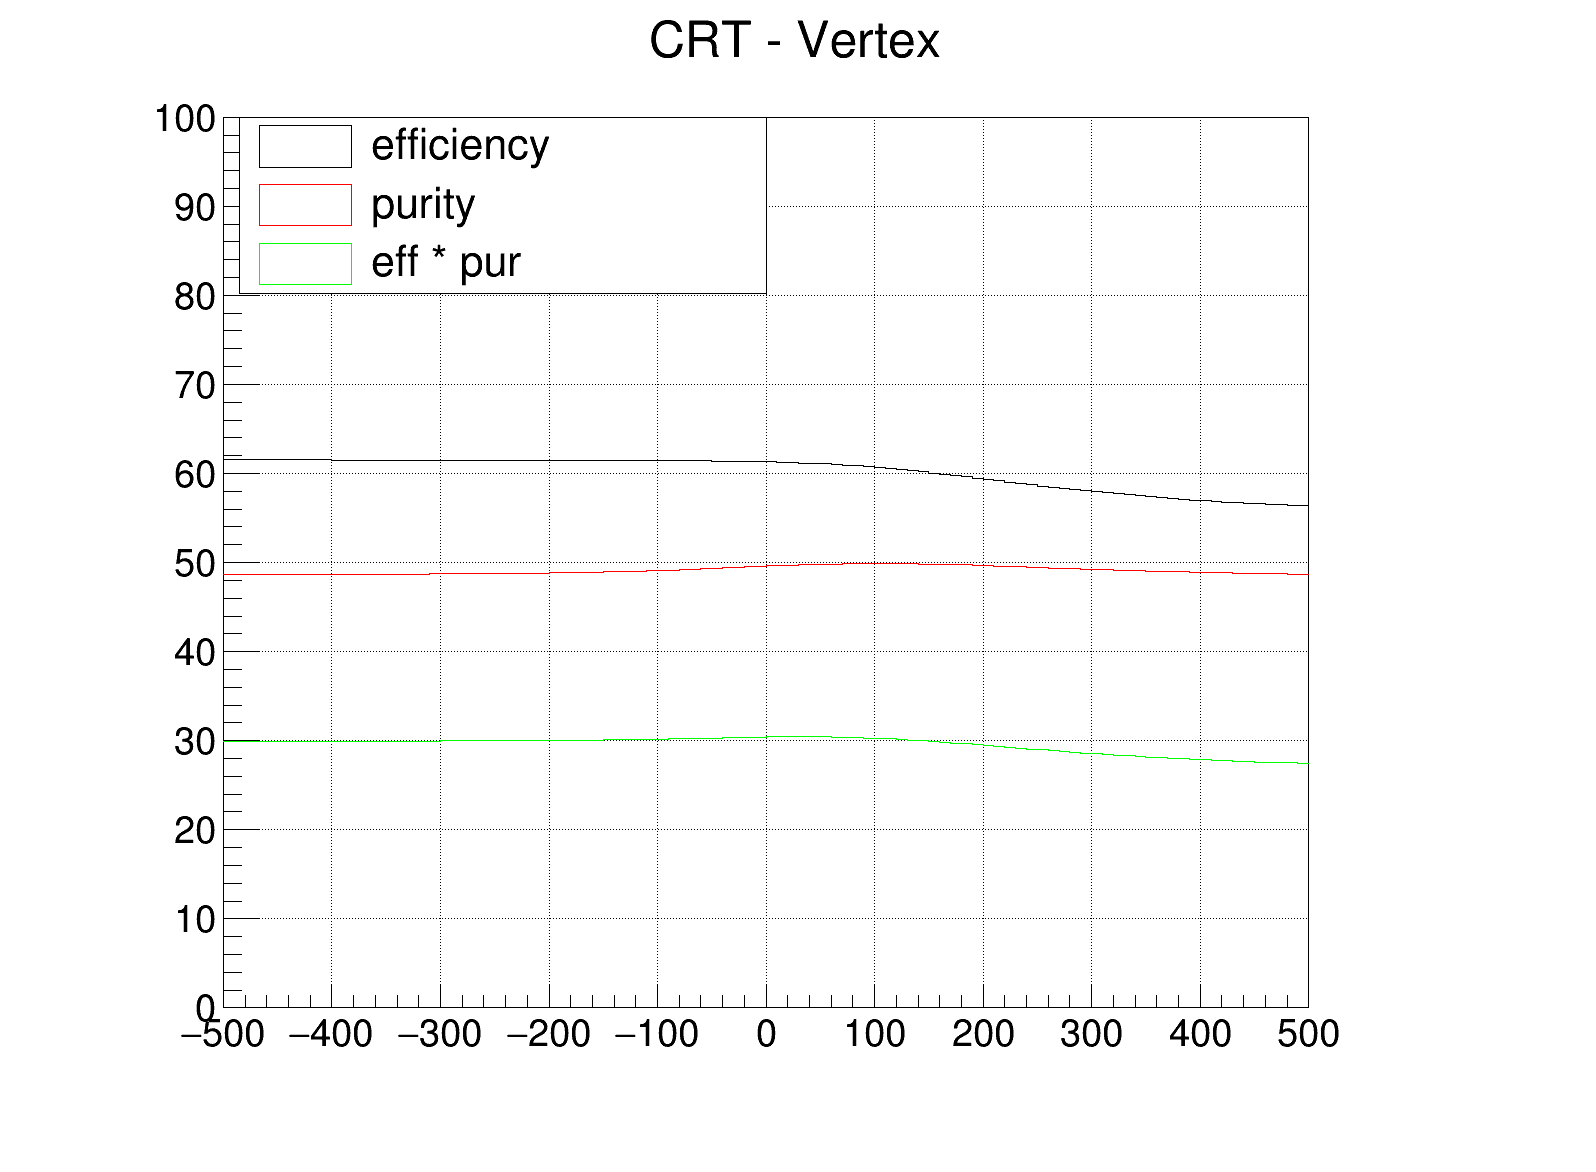

In [14]:
value = '(crthit_z - Nu_Vz_sce)'
xbins = 100
xstart = -500.0
xend = 500.0
step = (xend - xstart)/xbins
title = 'CRT - Vertex'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)

for i in range(xbins): 
    cut = 'muon && fidVol && TrackLength>8 && (track_uncontained==1 || nr_crthit_beam_tres==0) && nr_crthit_top==0 && crt_cut && ( crthit_z==9999 || '+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.Draw()
c1.SaveAs(outputdir_png+ value +"crtcut.png");
c1.SaveAs(outputdir_root+ value+ "crtcut.root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [12]:
NuCC.pdg_content_out('fidVol && muon')

Total number of entries:  283618.0
PDG:  13 	=	62.2% ,	error: 0.1%
PDG:  -1 	=	13.2% ,	error: 0.1%
PDG:  2212 	=	11.4% ,	error: 0.1%
PDG:  211 	=	4.3% ,	error: 0.0%
PDG:  2112 	=	3.6% ,	error: 0.0%
PDG:  22 	=	2.4% ,	error: 0.0%
PDG:  -211 	=	2.2% ,	error: 0.0%
PDG:  -13 	=	0.5% ,	error: 0.0%
PDG:  11 	=	0.1% ,	error: 0.0%
PDG:  321 	=	0.0% ,	error: 0.0%
PDG:  -11 	=	0.0% ,	error: 0.0%
PDG:  -321 	=	0.0% ,	error: 0.0%


In [31]:
NuCC.printEff('fidVol && muon')

Rejection on each sample:
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		66.84%
Purity:			37.34%
Purity*Efficiency	24.96

Amount of     ext:	33.00%
Amount of overlay:	62.13%
Amount of    dirt:	4.87%

Signal definition=  numu_lowpur: 2.24%	(3.60%)
Signal definition=   numu_other: 0.54%	(0.87%)
Signal definition=    numu_nomu: 4.87%	(7.83%)
Signal definition=      numu_ov: 9.58%	(15.42%)
Signal definition=  numu_signal: 37.34%	(60.11%)
Signal definition=      numu_nc: 7.55%	(12.15%)


In [14]:
NuCC.printEff_out('fidVol && muon && TrackLength>8')

Efficiency for cut:  fidVol && muon && TrackLength>8
Rejection on each sample:
Keep of     ext:	88.78%	 reject:	11.22%
Keep of overlay:	91.50%	 reject:	8.50%
Keep of    dirt:	85.30%	 reject:	14.70%

Efficiency:		66.63%
Purity:			38.81%
Purity*Efficiency	25.86

Amount of     ext:	32.62%
Amount of overlay:	62.68%
Amount of    dirt:	4.69%

Signal definition=  numu_lowpur: 2.24%	(3.57%)
Signal definition=   numu_other: 0.51%	(0.82%)
Signal definition=    numu_nomu: 4.85%	(7.74%)
Signal definition=      numu_ov: 9.25%	(14.76%)
Signal definition=  numu_signal: 38.81%	(61.91%)
Signal definition=      numu_nc: 7.02%	(11.20%)


In [12]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && (track_uncontained==1 || nr_crthit_beam_tres==0)')

Rejection on each sample:
Keep of     ext:	69.83%	 reject:	30.17%
Keep of overlay:	91.26%	 reject:	8.74%
Keep of    dirt:	76.76%	 reject:	23.24%

Efficiency:		64.72%
Purity:			43.32%
Purity*Efficiency	28.04

Amount of     ext:	27.61%
Amount of overlay:	67.92%
Amount of    dirt:	4.48%

Signal definition=  numu_lowpur: 2.33%	(3.43%)
Signal definition=   numu_other: 0.57%	(0.84%)
Signal definition=    numu_nomu: 4.55%	(6.70%)
Signal definition=      numu_ov: 9.31%	(13.71%)
Signal definition=  numu_signal: 43.32%	(63.79%)
Signal definition=      numu_nc: 7.84%	(11.54%)


In [13]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && (track_uncontained==1 || nr_crthit_beam_tres==0) && nr_crthit_top==0')

Rejection on each sample:
Keep of     ext:	58.23%	 reject:	41.77%
Keep of overlay:	90.20%	 reject:	9.80%
Keep of    dirt:	75.23%	 reject:	24.77%

Efficiency:		63.86%
Purity:			45.22%
Purity*Efficiency	28.88

Amount of     ext:	24.35%
Amount of overlay:	71.01%
Amount of    dirt:	4.64%

Signal definition=  numu_lowpur: 2.43%	(3.42%)
Signal definition=   numu_other: 0.60%	(0.84%)
Signal definition=    numu_nomu: 4.79%	(6.74%)
Signal definition=      numu_ov: 9.70%	(13.67%)
Signal definition=  numu_signal: 45.22%	(63.68%)
Signal definition=      numu_nc: 8.27%	(11.65%)


In [14]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0)')

Rejection on each sample:
Keep of     ext:	54.69%	 reject:	45.31%
Keep of overlay:	89.63%	 reject:	10.37%
Keep of    dirt:	65.69%	 reject:	34.31%

Efficiency:		63.59%
Purity:			46.19%
Purity*Efficiency	29.37

Amount of     ext:	23.46%
Amount of overlay:	72.38%
Amount of    dirt:	4.16%

Signal definition=  numu_lowpur: 2.47%	(3.42%)
Signal definition=   numu_other: 0.61%	(0.84%)
Signal definition=    numu_nomu: 4.90%	(6.76%)
Signal definition=      numu_ov: 9.73%	(13.44%)
Signal definition=  numu_signal: 46.19%	(63.81%)
Signal definition=      numu_nc: 8.48%	(11.71%)


In [15]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Rejection on each sample:
Keep of     ext:	44.16%	 reject:	55.84%
Keep of overlay:	83.30%	 reject:	16.70%
Keep of    dirt:	55.21%	 reject:	44.79%

Efficiency:		61.29%
Purity:			49.62%
Purity*Efficiency	30.42

Amount of     ext:	21.12%
Amount of overlay:	74.99%
Amount of    dirt:	3.90%

Signal definition=  numu_lowpur: 1.80%	(2.40%)
Signal definition=   numu_other: 0.64%	(0.85%)
Signal definition=    numu_nomu: 5.28%	(7.04%)
Signal definition=      numu_ov: 8.94%	(11.92%)
Signal definition=  numu_signal: 49.62%	(66.18%)
Signal definition=      numu_nc: 8.70%	(11.60%)


In [17]:
NuCC.pdg_content_out('fidVol && muon && TrackLength>32 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Total number of entries:  191857.0
PDG:  13 	=	79.3% ,	error: 0.2%
PDG:  2212 	=	7.4% ,	error: 0.1%
PDG:  -1 	=	4.2% ,	error: 0.0%
PDG:  211 	=	3.7% ,	error: 0.0%
PDG:  2112 	=	2.2% ,	error: 0.0%
PDG:  -211 	=	1.8% ,	error: 0.0%
PDG:  22 	=	0.7% ,	error: 0.0%
PDG:  -13 	=	0.6% ,	error: 0.0%
PDG:  11 	=	0.1% ,	error: 0.0%
PDG:  321 	=	0.0% ,	error: 0.0%
PDG:  -11 	=	0.0% ,	error: 0.0%
PDG:  -321 	=	0.0% ,	error: 0.0%


In [19]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && nr_crthit_beam_tres==0')

Rejection on each sample:
Keep of     ext:	50.83%	 reject:	49.17%
Keep of overlay:	83.58%	 reject:	16.42%
Keep of    dirt:	63.75%	 reject:	36.25%

Efficiency:		57.92%
Purity:			45.07%
Purity*Efficiency	26.10

Amount of     ext:	23.36%
Amount of overlay:	72.32%
Amount of    dirt:	4.32%

Signal definition=  numu_lowpur: 2.56%	(3.54%)
Signal definition=   numu_other: 0.62%	(0.86%)
Signal definition=    numu_nomu: 5.17%	(7.15%)
Signal definition=      numu_ov: 9.84%	(13.61%)
Signal definition=  numu_signal: 45.07%	(62.32%)
Signal definition=      numu_nc: 9.05%	(12.51%)


In [23]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Rejection on each sample:
Keep of     ext:	44.16%	 reject:	55.84%
Keep of overlay:	83.30%	 reject:	16.70%
Keep of    dirt:	55.21%	 reject:	44.79%

Efficiency:		61.29%
Purity:			49.62%
Purity*Efficiency	30.42

Amount of     ext:	21.12%
Amount of overlay:	74.99%
Amount of    dirt:	3.90%

Signal definition=  numu_lowpur: 1.80%	(2.40%)
Signal definition=   numu_other: 0.64%	(0.85%)
Signal definition=    numu_nomu: 5.28%	(7.04%)
Signal definition=      numu_ov: 8.94%	(11.92%)
Signal definition=  numu_signal: 49.62%	(66.18%)
Signal definition=      numu_nc: 8.70%	(11.60%)


In [20]:
NuCC.printEff_out('fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)')


Rejection on each sample:
Keep of     ext:	26.96%	 reject:	73.04%
Keep of overlay:	62.03%	 reject:	37.97%
Keep of    dirt:	32.28%	 reject:	67.72%

Efficiency:		54.67%
Purity:			62.33%
Purity*Efficiency	34.07

Amount of     ext:	18.15%
Amount of overlay:	78.64%
Amount of    dirt:	3.21%

Signal definition=  numu_lowpur: 0.78%	(1.00%)
Signal definition=   numu_other: 0.67%	(0.85%)
Signal definition=    numu_nomu: 4.21%	(5.35%)
Signal definition=      numu_ov: 6.01%	(7.64%)
Signal definition=  numu_signal: 62.33%	(79.26%)
Signal definition=      numu_nc: 4.63%	(5.89%)


In [22]:
NuCC.printEff_out('fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')


Rejection on each sample:
Keep of     ext:	13.48%	 reject:	86.52%
Keep of overlay:	55.31%	 reject:	44.69%
Keep of    dirt:	19.29%	 reject:	80.71%

Efficiency:		50.49%
Purity:			70.97%
Purity*Efficiency	35.83

Amount of     ext:	11.19%
Amount of overlay:	86.44%
Amount of    dirt:	2.36%

Signal definition=  numu_lowpur: 0.58%	(0.67%)
Signal definition=   numu_other: 0.73%	(0.84%)
Signal definition=    numu_nomu: 4.06%	(4.70%)
Signal definition=      numu_ov: 5.38%	(6.22%)
Signal definition=  numu_signal: 70.97%	(82.10%)
Signal definition=      numu_nc: 4.72%	(5.46%)


In [21]:
nenner_cut = "numu_true"
zahler_cut = "numu_signal && fidVol && muon"
cut =  "fidVol && muon"
name = '_ini'
title = 'Initial:'


NuCC.plot_effV2(nenner_cut, zahler_cut, cut, name, title)

Efficiency:	66.84%
Purity:		37.34%


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_energy_ini.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_energy_ini.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_theta_ini.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_theta_ini.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_phi_ini.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_phi_ini.root has been created
Info in <TCanvas::Print>: png file /home/tme

In [16]:
nenner_cut = "numu_true"
zahler_cut = "numu_signal && fidVol && muon && TrackLength>8"
cut =  "fidVol && muon && TrackLength>8"
name = '_tracklen'
title = 'After track length cut only:'

NuCC.plot_eff_outV2(nenner_cut, zahler_cut, cut, name, title)

Efficiency:	66.63%
Purity:		38.81%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_energy_tracklen.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_energy_tracklen.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_theta_tracklen.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_theta_tracklen.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_phi_tracklen.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_phi_tracklen.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_1

In [17]:
nenner_cut = "numu_true"
zahler_cut = "numu_signal && fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut"
cut =  "fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut"
name = '_CRTtom'
title = 'After toms CRT cut:'

NuCC.plot_eff_outV2(nenner_cut, zahler_cut, cut, name, title)

Efficiency:	61.29%
Purity:		49.62%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_energy_CRTtom.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_energy_CRTtom.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_theta_CRTtom.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_theta_CRTtom.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_phi_CRTtom.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_phi_CRTtom.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_

In [18]:
nenner_cut = "numu_signal"
zahler_cut = "numu_signal && fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut"
cut =  "fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut"
name = '_CRTtomOnly'
title = 'After toms CRT cut:'

NuCC.plot_eff_outV2(nenner_cut, zahler_cut, cut, name, title)

Efficiency:	91.71%
Purity:		49.62%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_energy_CRTtomOnly.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_energy_CRTtomOnly.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_theta_CRTtomOnly.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_theta_CRTtomOnly.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_phi_CRTtomOnly.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_phi_CRTtomOnly.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1

In [19]:
nenner_cut = "numu_true"
zahler_cut = "numu_signal && fidVol && muon && TrackLength>8 && nr_crthit_beam_tres==0"
cut =  "fidVol && muon && TrackLength>8 && nr_crthit_beam_tres==0"
name = '_CRTveto'
title = 'After total CRT veto:'

NuCC.plot_eff_outV2(nenner_cut, zahler_cut, cut, name, title)

Efficiency:	57.92%
Purity:		45.07%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_energy_CRTveto.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_energy_CRTveto.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_theta_CRTveto.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_theta_CRTveto.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/h_eff_phi_CRTveto.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/h_eff_phi_CRTveto.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/N

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/NuVx_sce_CRTcut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//root/NuVx_sce_CRTcut.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacin

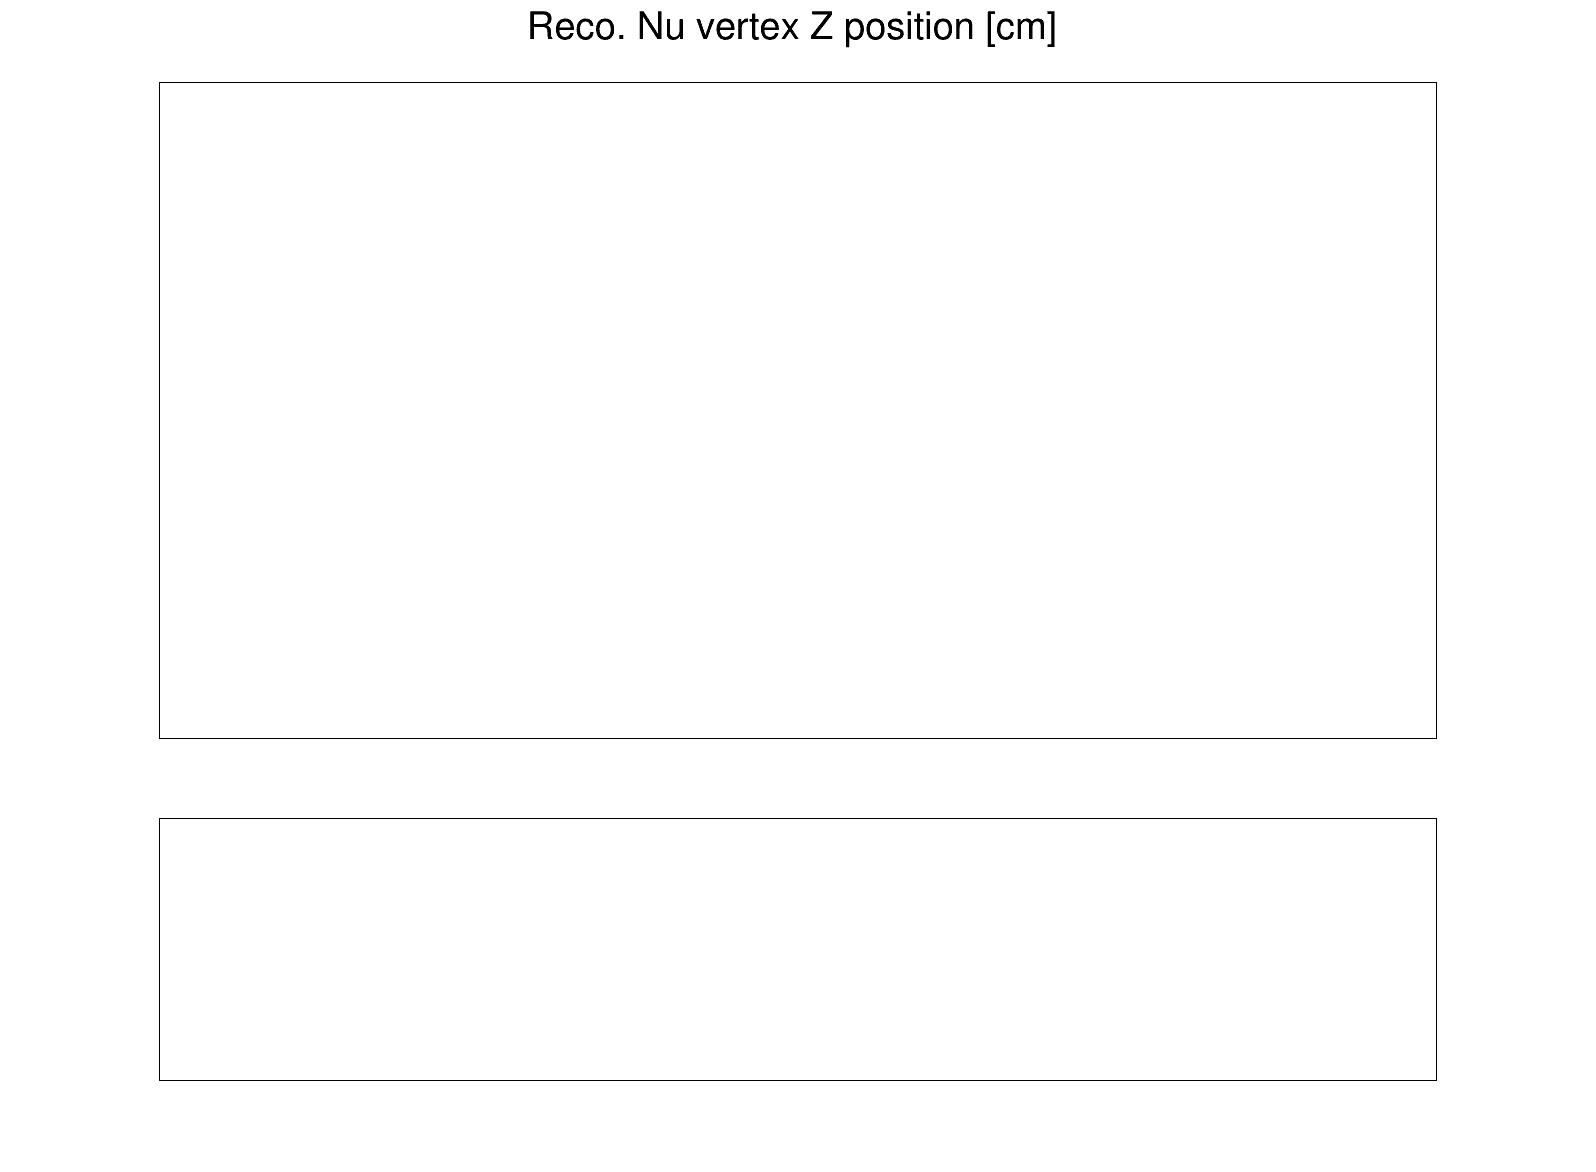

In [58]:
# Generate stacked histograms with crt cut and tracklength cut
cut = 'fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'
name = '_CRTcut'

NuCC.make_stacked_histo_plot_out(cut,'Nu_Vx_sce','Reco. Nu vertex X position [cm]',0,250,25,'NuVx_sce'+name)
NuCC.make_stacked_histo_plot_out(cut,'Nu_Vy_sce','Reconstructed neutrino vertex Y position [cm]',-110,115,22,'NuVy_sce'+name)
NuCC.make_stacked_histo_plot_out(cut,'Nu_Vz_sce','Reco. Nu vertex Z position [cm]',-20,1020,100,'NuVz_sce'+name)

"\nNuCC.make_stacked_histo_plot_out(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)\nNuCC.make_stacked_histo_plot_out(cut,'TrackLength','Track length [cm]',0,500,20,'tracklength'+name)\nNuCC.make_stacked_histo_plot_out(cut + ' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)\nNuCC.make_stacked_histo_plot_out(cut + ' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)\nNuCC.make_stacked_histo_plot_out(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)\nNuCC.make_stacked_histo_plot_out(cut,'NuTracks','Number of tracks',0,8,8,'num_track'+name)\n\nNuCC.make_stacked_histo_plot_out(cut,'Nu_Vx_sce','Reco. Nu vertex X position [cm]',0,250,25,'NuVx_sce'+name)\nNuCC.make_stacked_histo_plot_out(cut,'Nu_Vy_sce','Reconstructed neutrino vertex Y position [cm]',-110,115,22,'NuVy_sce'+name)\nNuCC.make_stacked_histo_plot_out(cut,'Nu_Vz_sce','Reco. Nu vertex Z position [cm]',-20,1020,100,'NuVz_sce'+name)\n"

Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_crt_cut//png/FlashTime_corr_CRTcut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08

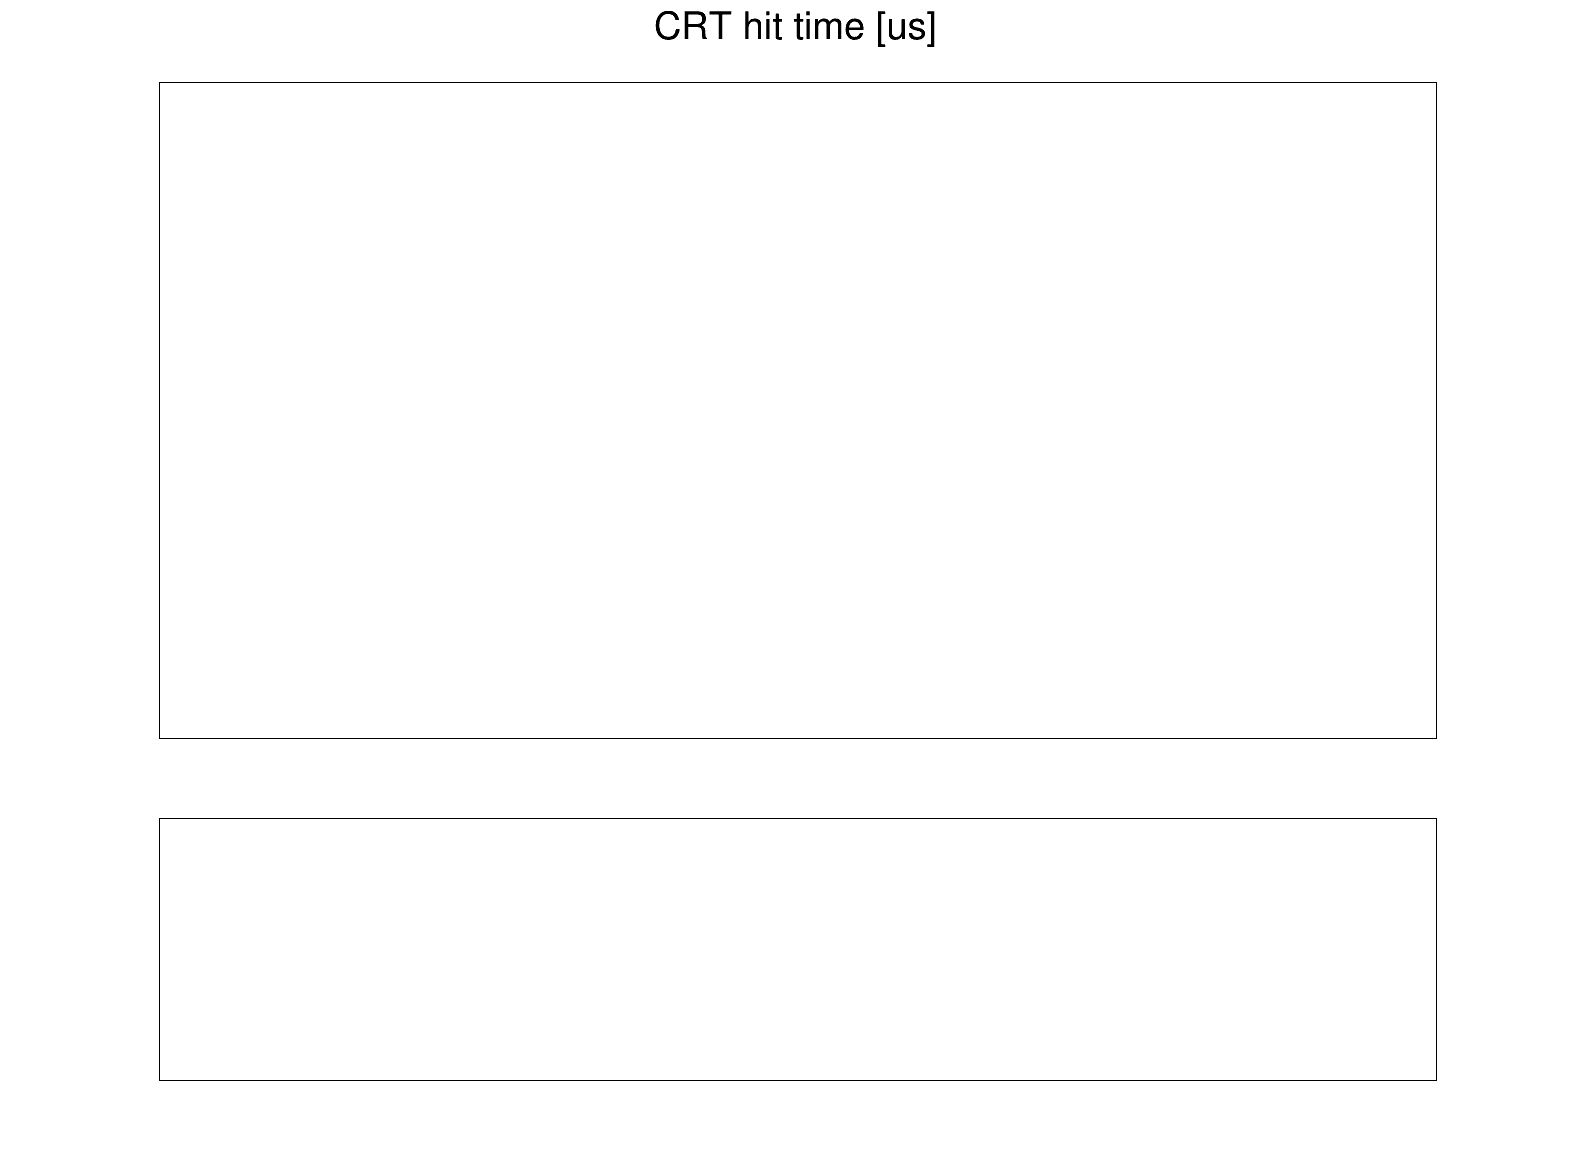

In [36]:
# Generate stacked histograms with crt cut and tracklength cut
cut = 'fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'
name = '_CRTcut'

NuCC.make_stacked_histo_plot_flashcorr_out(cut,'TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr'+name)
NuCC.make_stacked_histo_plot_crtcorr_out(cut,'crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr'+name)
'''
NuCC.make_stacked_histo_plot_out(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)
NuCC.make_stacked_histo_plot_out(cut,'TrackLength','Track length [cm]',0,500,20,'tracklength'+name)
NuCC.make_stacked_histo_plot_out(cut + ' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
NuCC.make_stacked_histo_plot_out(cut + ' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)
NuCC.make_stacked_histo_plot_out(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)
NuCC.make_stacked_histo_plot_out(cut,'NuTracks','Number of tracks',0,8,8,'num_track'+name)

NuCC.make_stacked_histo_plot_out(cut,'Nu_Vx_sce','Reco. Nu vertex X position [cm]',0,250,25,'NuVx_sce'+name)
NuCC.make_stacked_histo_plot_out(cut,'Nu_Vy_sce','Reconstructed neutrino vertex Y position [cm]',-110,115,22,'NuVy_sce'+name)
NuCC.make_stacked_histo_plot_out(cut,'Nu_Vz_sce','Reco. Nu vertex Z position [cm]',-20,1020,100,'NuVz_sce'+name)
'''

In [15]:
crt_tom_cut = ' nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'
data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

True

Events in the file: 302777  with number of Piont: 8124.0


Warning in <TROOT::Append>: Replacing existing TH1: h_2d_Pnt (Potential memory leak).


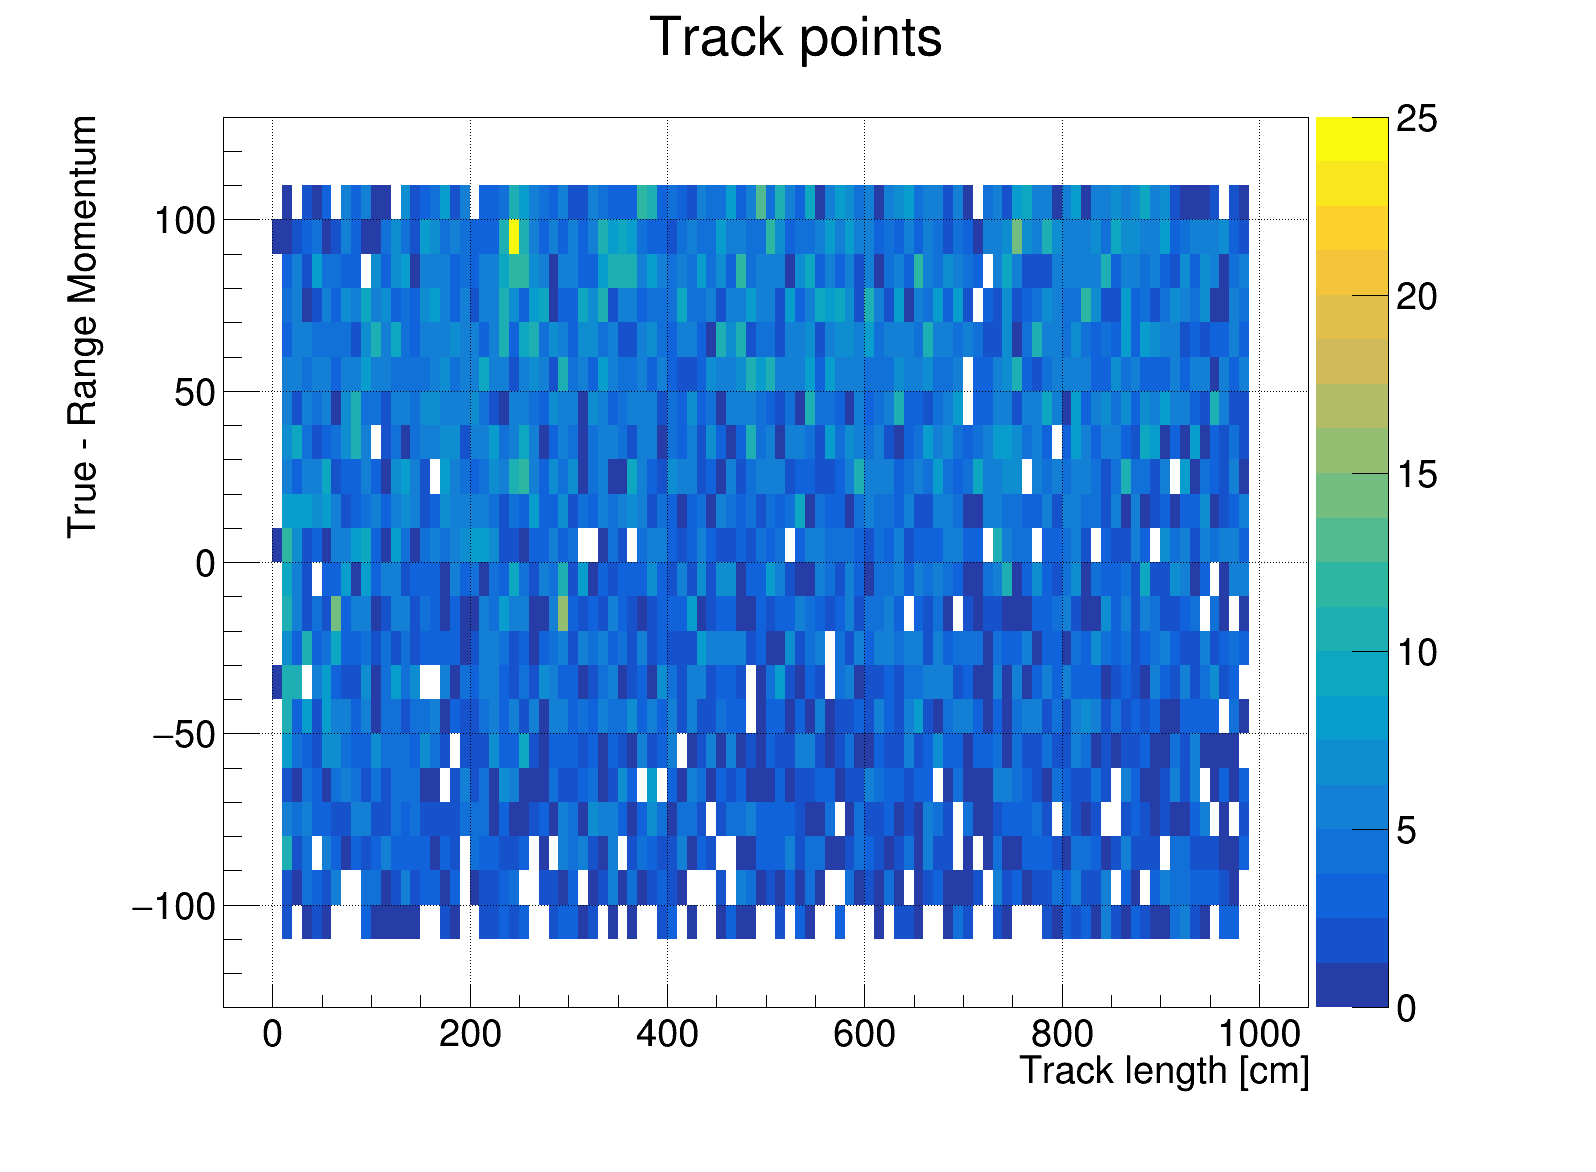

In [16]:
title = 'Track points'
xbin = 110
xstart = -50
xend = 1050
ybin = 26
ystart = -130
yend = 130
event_nr = 7
data_set = ext_out
cut = 'fidVol && TrackLength>8 && crt_tom_cut && muon'
#cut = '1'
h_2d_Pnt = ROOT.TH2F("h_2d_Pnt", title, xbin,xstart,xend,ybin,ystart,yend)
h_2d_Pnt.SetXTitle("Track length [cm]")
h_2d_Pnt.SetYTitle("True - Range Momentum")
data_set.Draw('Nu_Vy_sce:Nu_Vz_sce>>h_2d_Pnt',cut,'')
h_2d_Pnt.Draw('colz')
c1.SetLogy(0)
c1.Draw()
print 'Events in the file:', data_set.GetEntries(),' with number of Piont:', h_2d_Pnt.GetEntries()
#c1.SaveAs(outputdir_png + "h_range_contained_tracklength.png")
#c1.SaveAs(outputdir_root + "h_range_contained_tracklength.root")


Events in the file: 967267  with number of Piont: 223317.0


Warning in <TROOT::Append>: Replacing existing TH1: h_2d_Pnt (Potential memory leak).


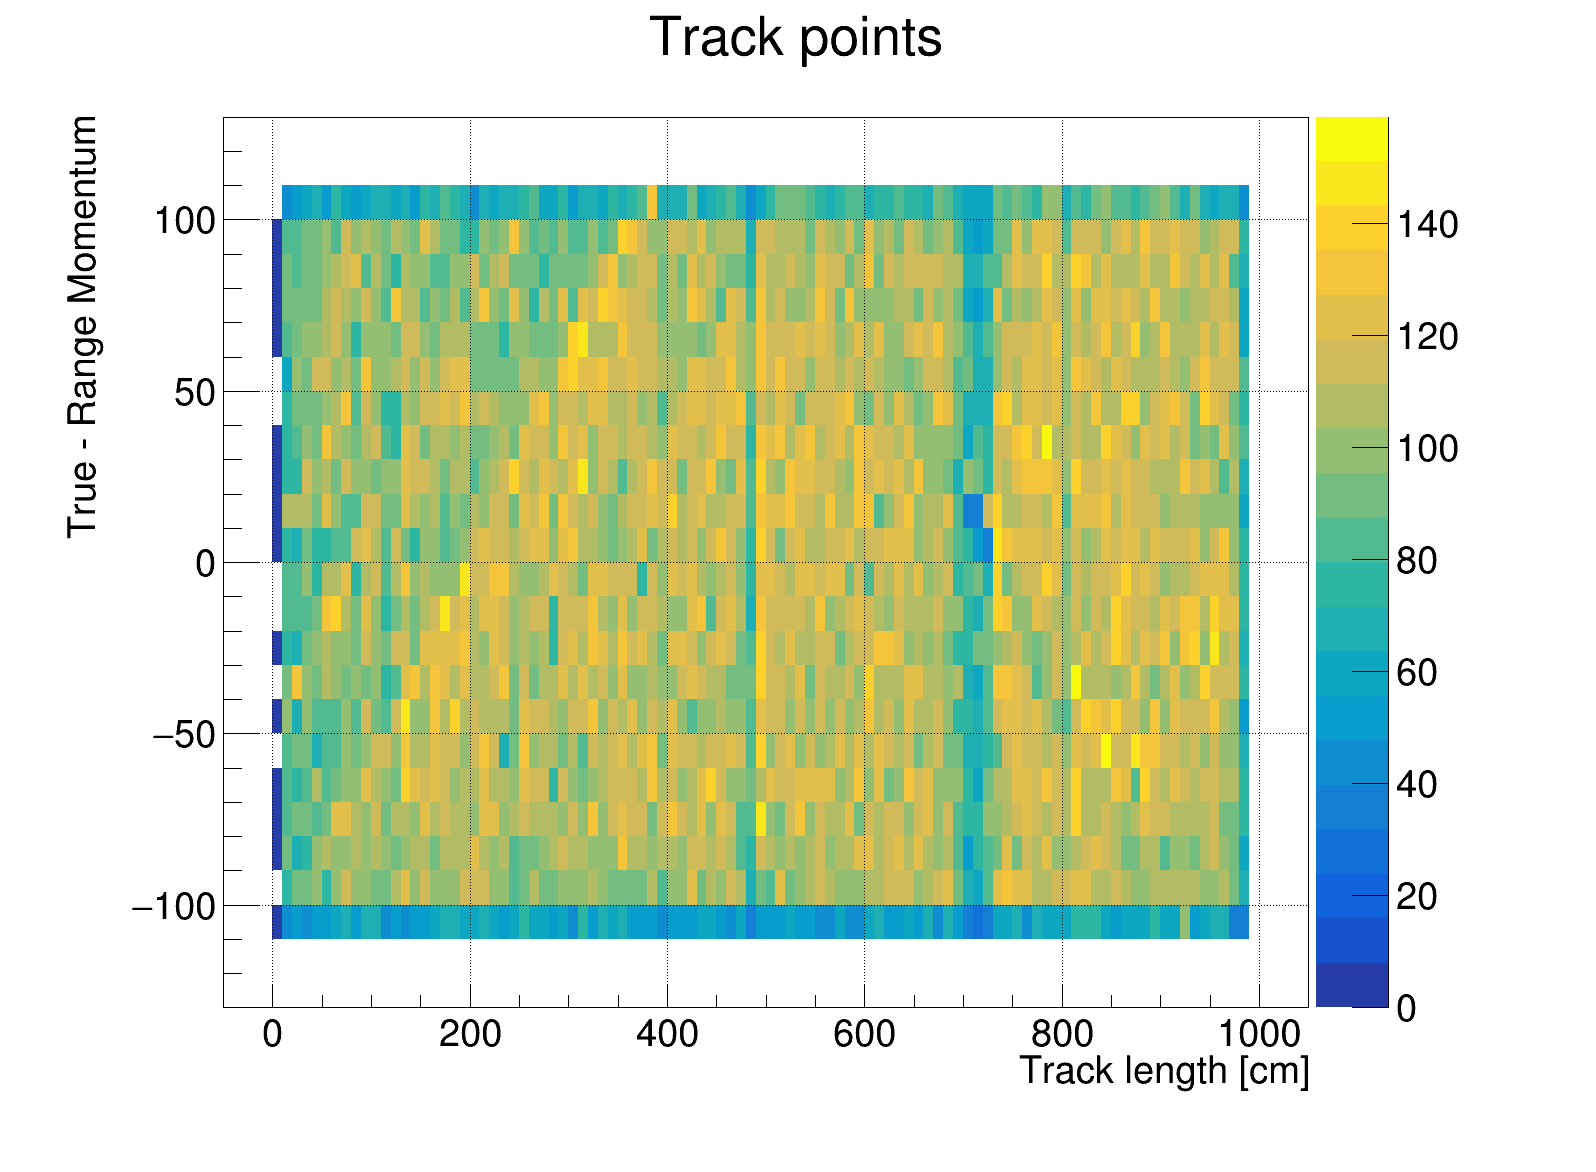

In [17]:
title = 'Track points'
xbin = 110
xstart = -50
xend = 1050
ybin = 26
ystart = -130
yend = 130
event_nr = 7
data_set = overlay_out
cut = 'fidVol && TrackLength>8 && crt_tom_cut && muon'
#cut = '1'
h_2d_Pnt = ROOT.TH2F("h_2d_Pnt", title, xbin,xstart,xend,ybin,ystart,yend)
h_2d_Pnt.SetXTitle("Track length [cm]")
h_2d_Pnt.SetYTitle("True - Range Momentum")
data_set.Draw('Nu_Vy_sce:Nu_Vz_sce>>h_2d_Pnt',cut,'')
h_2d_Pnt.Draw('colz')
c1.SetLogy(0)
c1.Draw()
print 'Events in the file:', data_set.GetEntries(),' with number of Piont:', h_2d_Pnt.GetEntries()
#c1.SaveAs(outputdir_png + "h_range_contained_tracklength.png")
#c1.SaveAs(outputdir_root + "h_range_contained_tracklength.root")


Events in the file: 96464  with number of Piont: 2860.0


Warning in <TROOT::Append>: Replacing existing TH1: h_2d_Pnt (Potential memory leak).


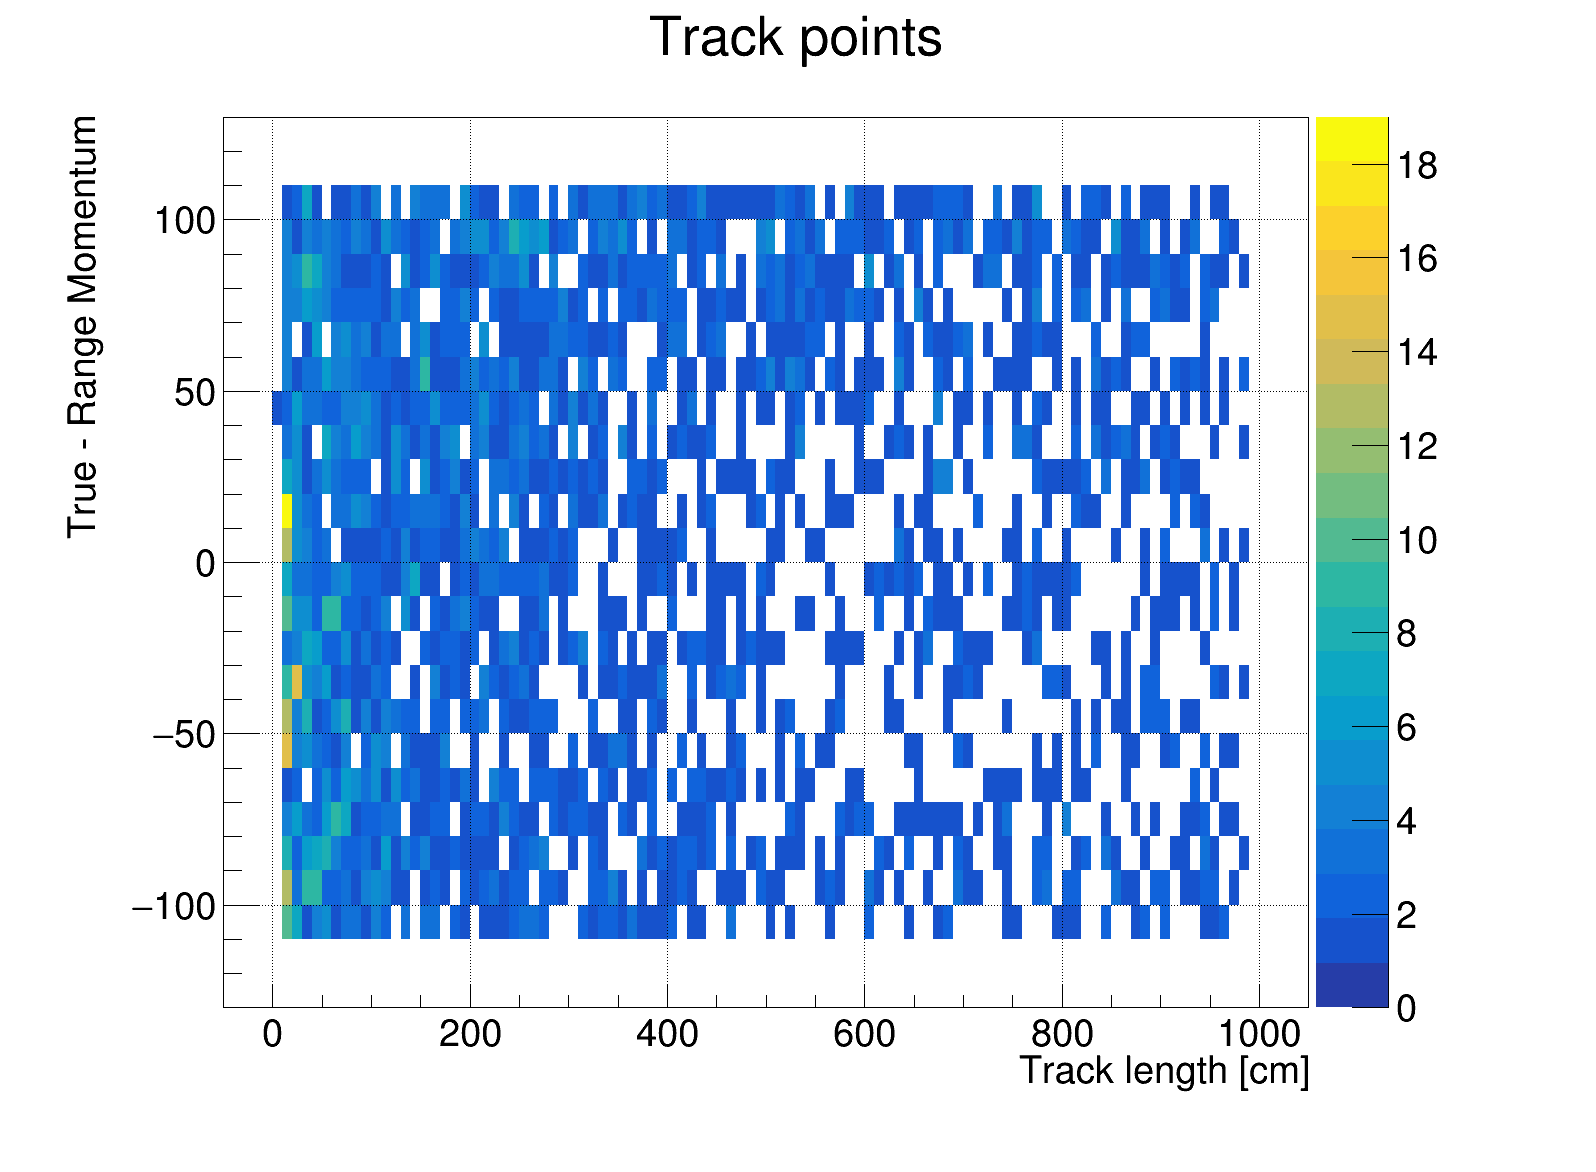

In [18]:
title = 'Track points'
xbin = 110
xstart = -50
xend = 1050
ybin = 26
ystart = -130
yend = 130
event_nr = 7
data_set = dirt_out
cut = 'fidVol && TrackLength>8 && crt_tom_cut && muon'
#cut = '1'
h_2d_Pnt = ROOT.TH2F("h_2d_Pnt", title, xbin,xstart,xend,ybin,ystart,yend)
h_2d_Pnt.SetXTitle("Track length [cm]")
h_2d_Pnt.SetYTitle("True - Range Momentum")
data_set.Draw('Nu_Vy_sce:Nu_Vz_sce>>h_2d_Pnt',cut,'')
h_2d_Pnt.Draw('colz')
c1.SetLogy(0)
c1.Draw()
print 'Events in the file:', data_set.GetEntries(),' with number of Piont:', h_2d_Pnt.GetEntries()
#c1.SaveAs(outputdir_png + "h_range_contained_tracklength.png")
#c1.SaveAs(outputdir_root + "h_range_contained_tracklength.root")


Events in the file: 302777  with number of Piont: 8124.0


Warning in <TROOT::Append>: Replacing existing TH1: h_2d_Pnt (Potential memory leak).


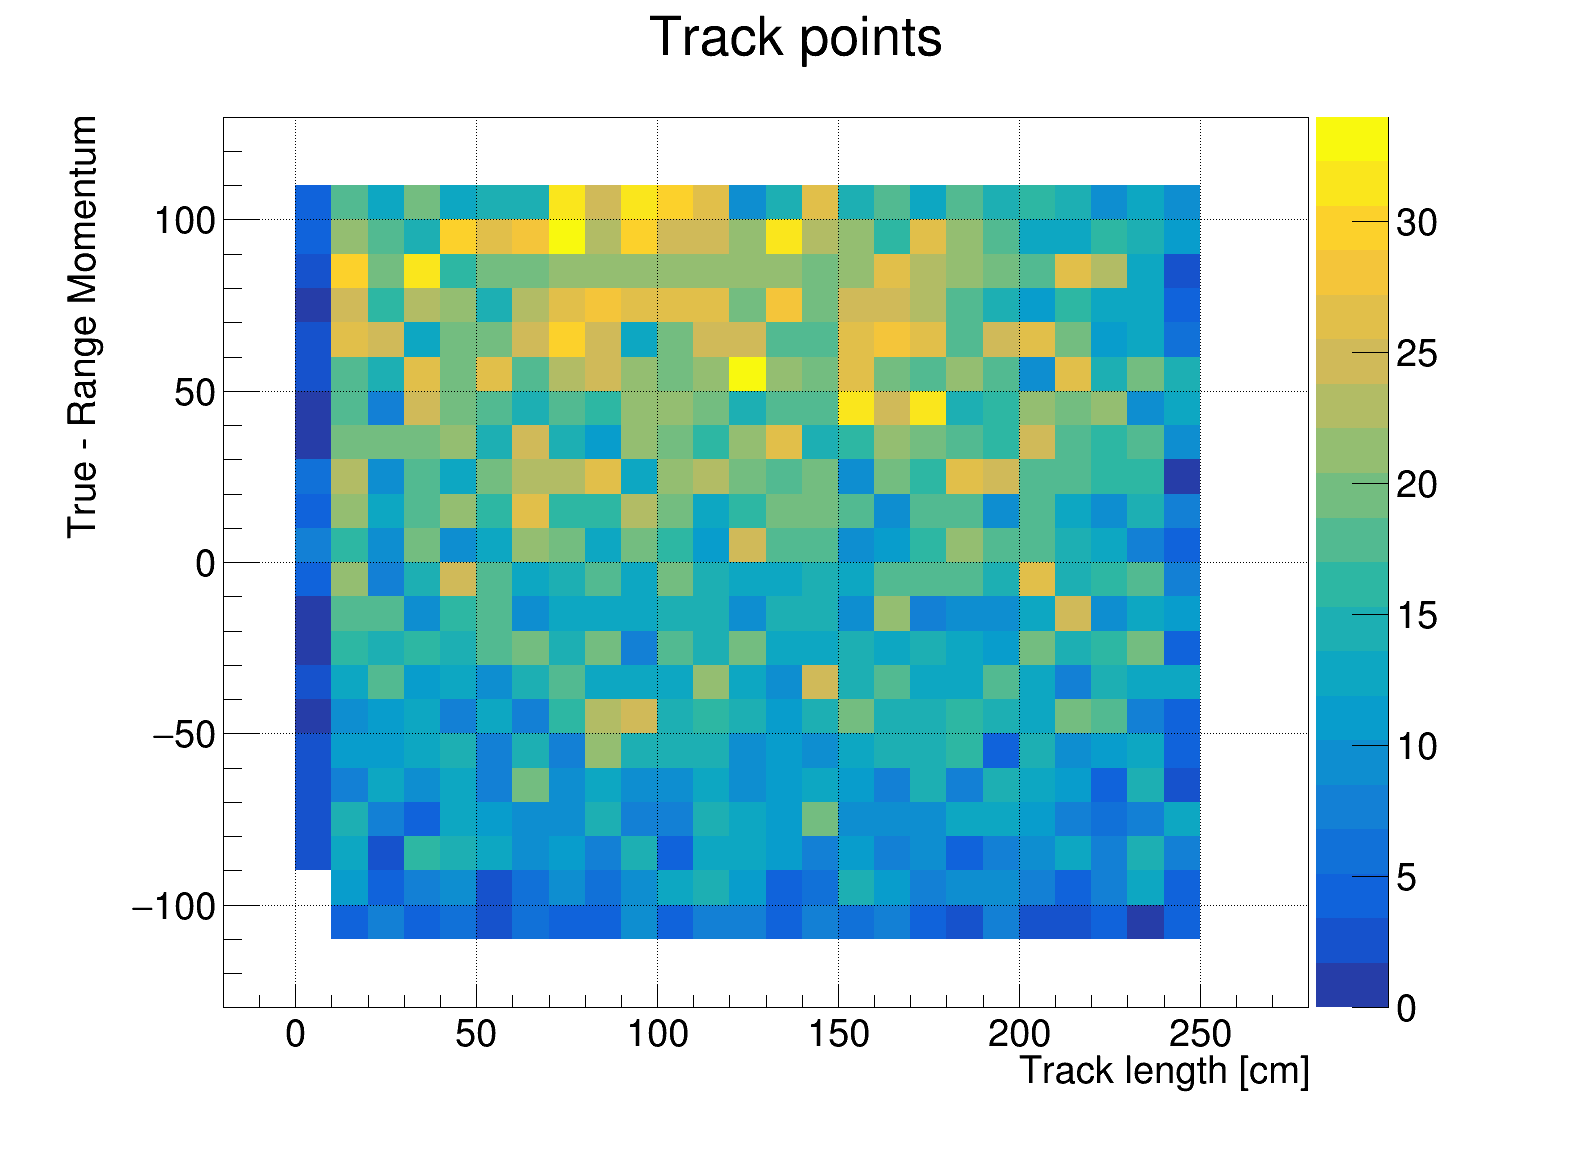

In [21]:
title = 'Track points'
xbin = 30
xstart = -20
xend = 280
ybin = 26
ystart = -130
yend = 130
event_nr = 7
data_set = ext_out
cut = 'fidVol && TrackLength>8 && crt_tom_cut && muon'
#cut = '1'
h_2d_Pnt = ROOT.TH2F("h_2d_Pnt", title, xbin,xstart,xend,ybin,ystart,yend)
h_2d_Pnt.SetXTitle("Track length [cm]")
h_2d_Pnt.SetYTitle("True - Range Momentum")
data_set.Draw('Nu_Vy_sce:Nu_Vx_sce>>h_2d_Pnt',cut,'')
h_2d_Pnt.Draw('colz')
c1.SetLogy(0)
c1.Draw()
print 'Events in the file:', data_set.GetEntries(),' with number of Piont:', h_2d_Pnt.GetEntries()
#c1.SaveAs(outputdir_png + "h_range_contained_tracklength.png")
#c1.SaveAs(outputdir_root + "h_range_contained_tracklength.root")


Events in the file: 967267  with number of Piont: 223317.0


Warning in <TROOT::Append>: Replacing existing TH1: h_2d_Pnt (Potential memory leak).


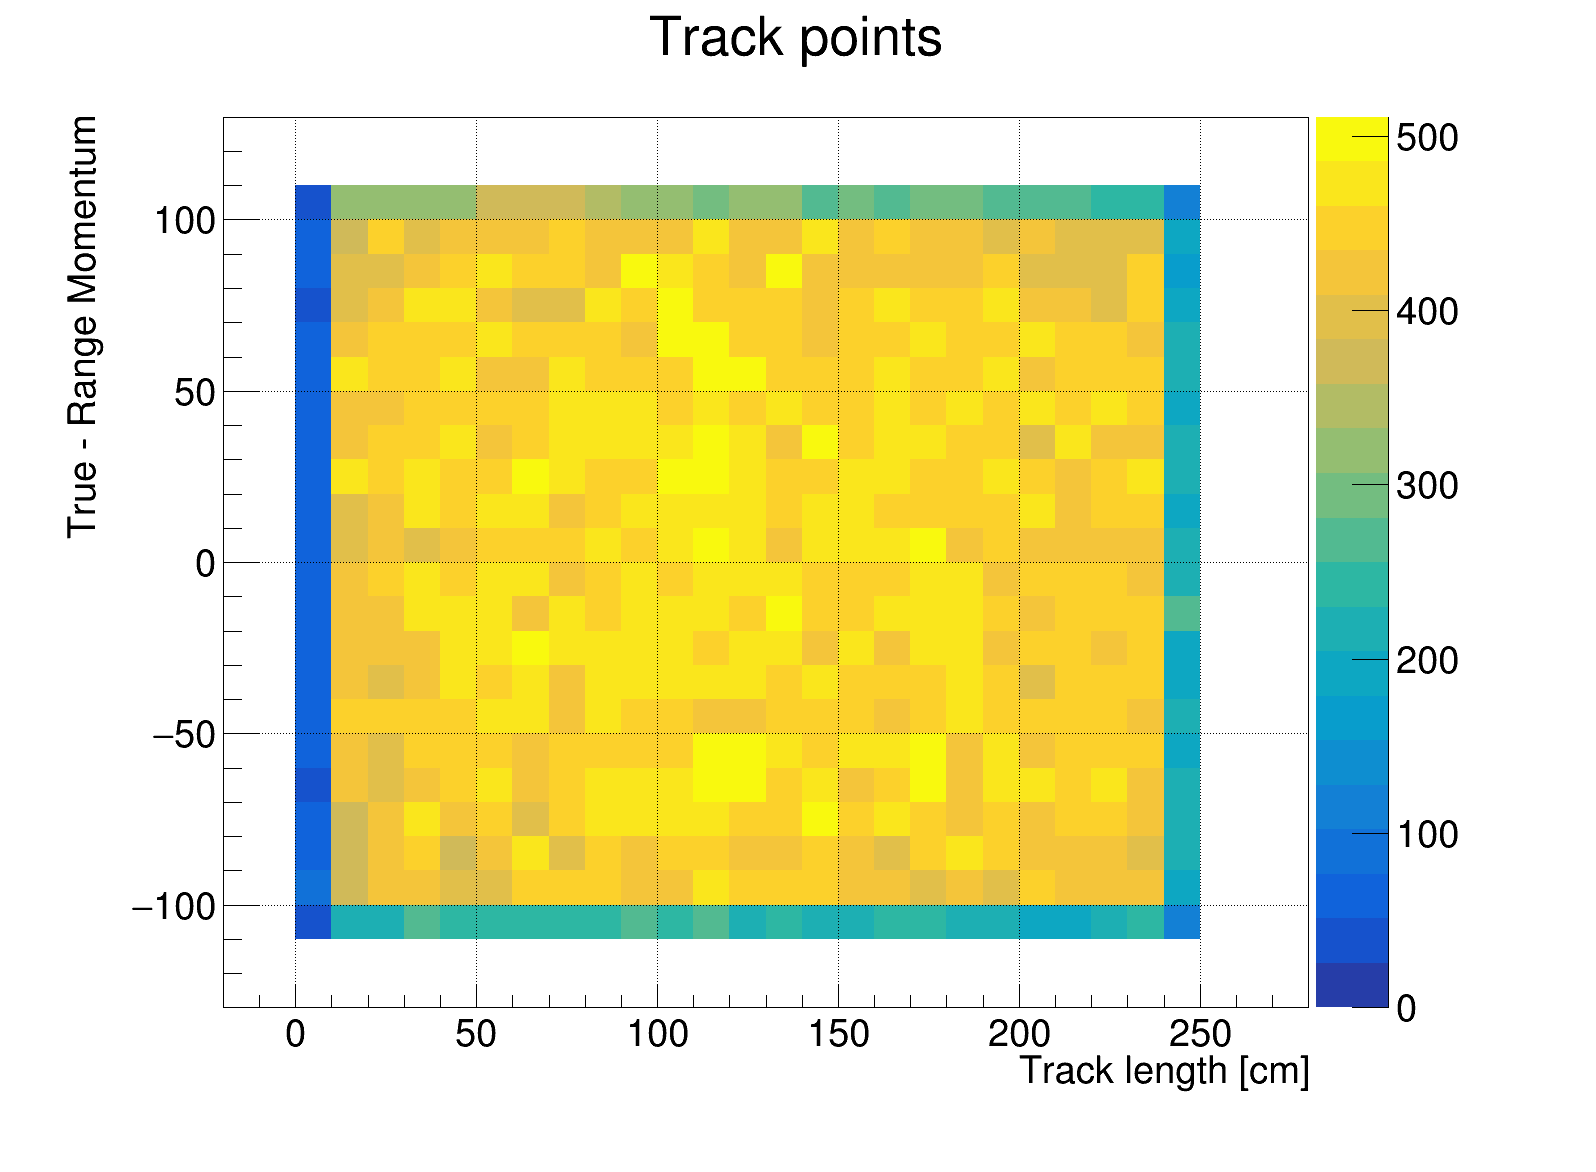

In [22]:
title = 'Track points'
xbin = 30
xstart = -20
xend = 280
ybin = 26
ystart = -130
yend = 130
event_nr = 7
data_set = overlay_out
cut = 'fidVol && TrackLength>8 && crt_tom_cut && muon'
#cut = '1'
h_2d_Pnt = ROOT.TH2F("h_2d_Pnt", title, xbin,xstart,xend,ybin,ystart,yend)
h_2d_Pnt.SetXTitle("Track length [cm]")
h_2d_Pnt.SetYTitle("True - Range Momentum")
data_set.Draw('Nu_Vy_sce:Nu_Vx_sce>>h_2d_Pnt',cut,'')
h_2d_Pnt.Draw('colz')
c1.SetLogy(0)
c1.Draw()
print 'Events in the file:', data_set.GetEntries(),' with number of Piont:', h_2d_Pnt.GetEntries()
#c1.SaveAs(outputdir_png + "h_range_contained_tracklength.png")
#c1.SaveAs(outputdir_root + "h_range_contained_tracklength.root")


Efficiency:	83.11%
Purity:		62.65%
Efficiency 2:	65.53%
Purity 2:		31.39%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter_forBackward_reco.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter_forBackward_reco.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta2 

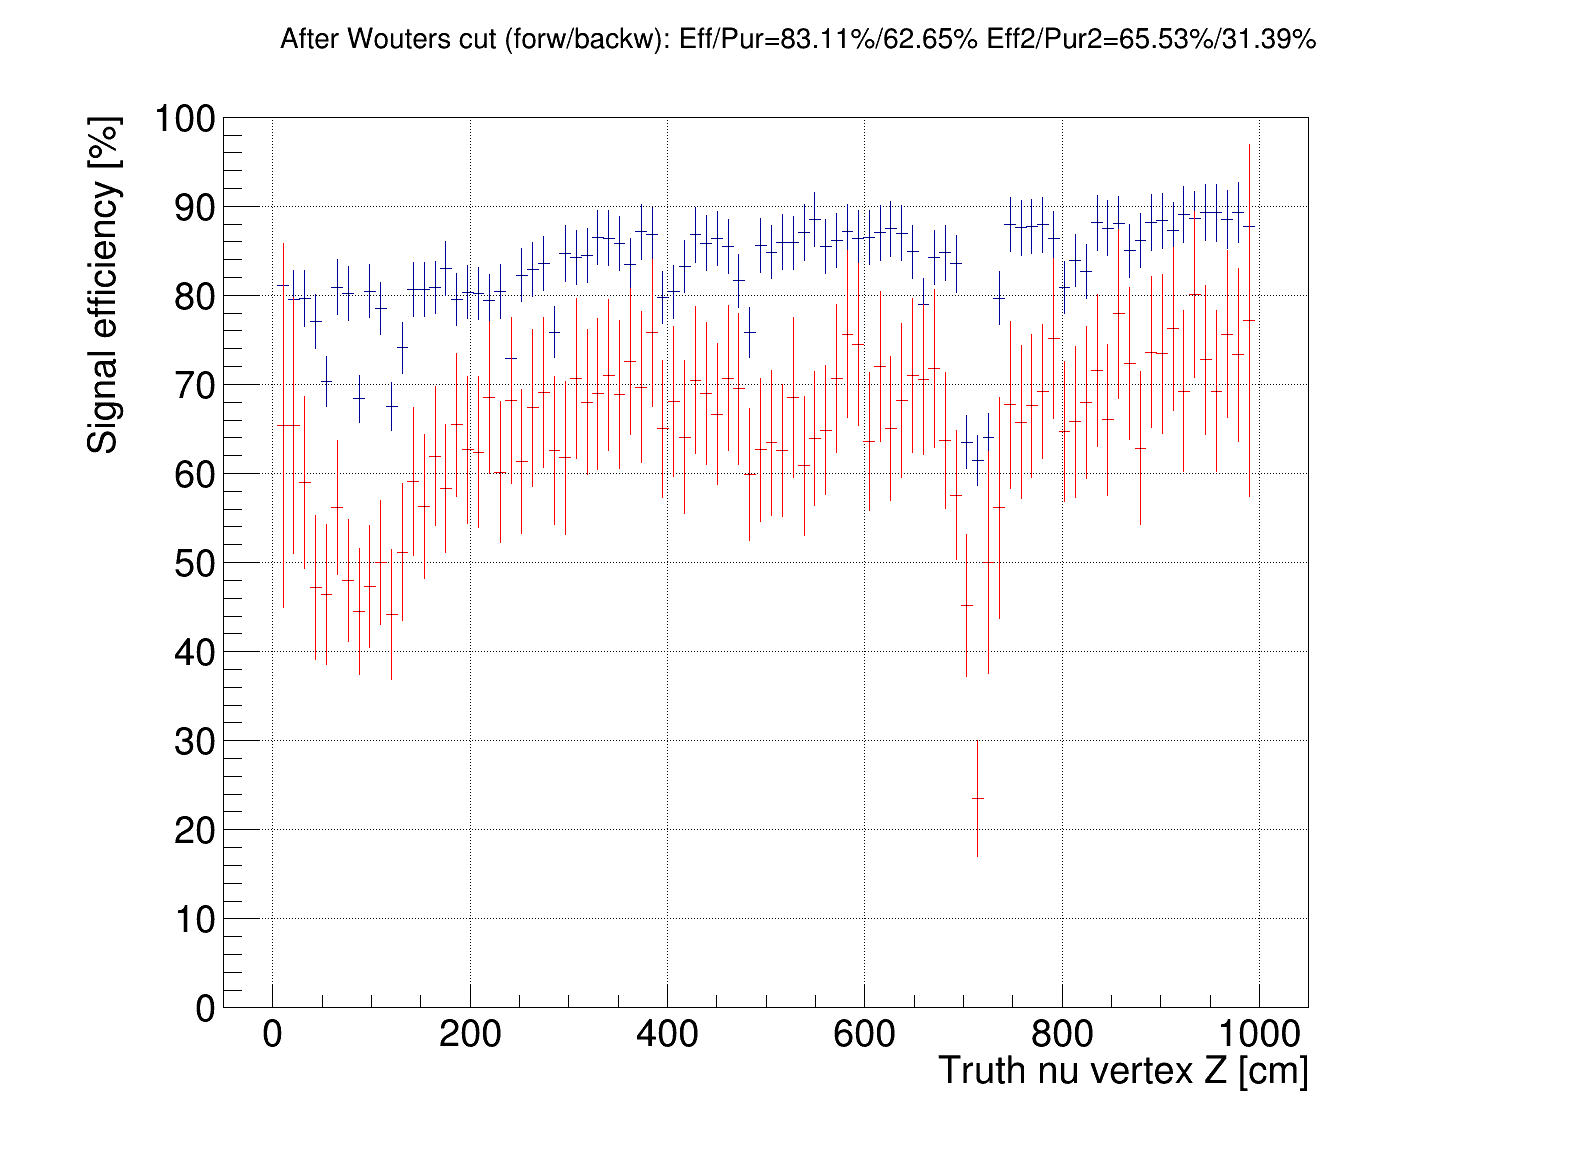

In [30]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && cos(TrackTheta)>0"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)>0"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)>0'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && cos(TrackTheta)<0"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)<0"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)<0'

efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_forBackward_reco'
title = 'After Wouters cut (forw/backw):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



In [26]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && !track_end_uncontained"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && !track_end_uncontained"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && !track_end_uncontained'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && track_end_uncontained"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && track_end_uncontained"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && track_end_uncontained'

efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_contained'
title = 'After Wouters cut (track_end_uncontained/!):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



Efficiency:	80.95%
Purity:		58.92%
Efficiency 2:	84.34%
Purity 2:		57.84%


AttributeError: 'PyROOT_NoneType' object has no attribute 'Draw'

Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).


Efficiency:	71.05%
Purity:		39.55%
Efficiency 2:	84.13%
Purity 2:		65.00%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter_NuTracks.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter_NuTracks.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta2 (Potential memor

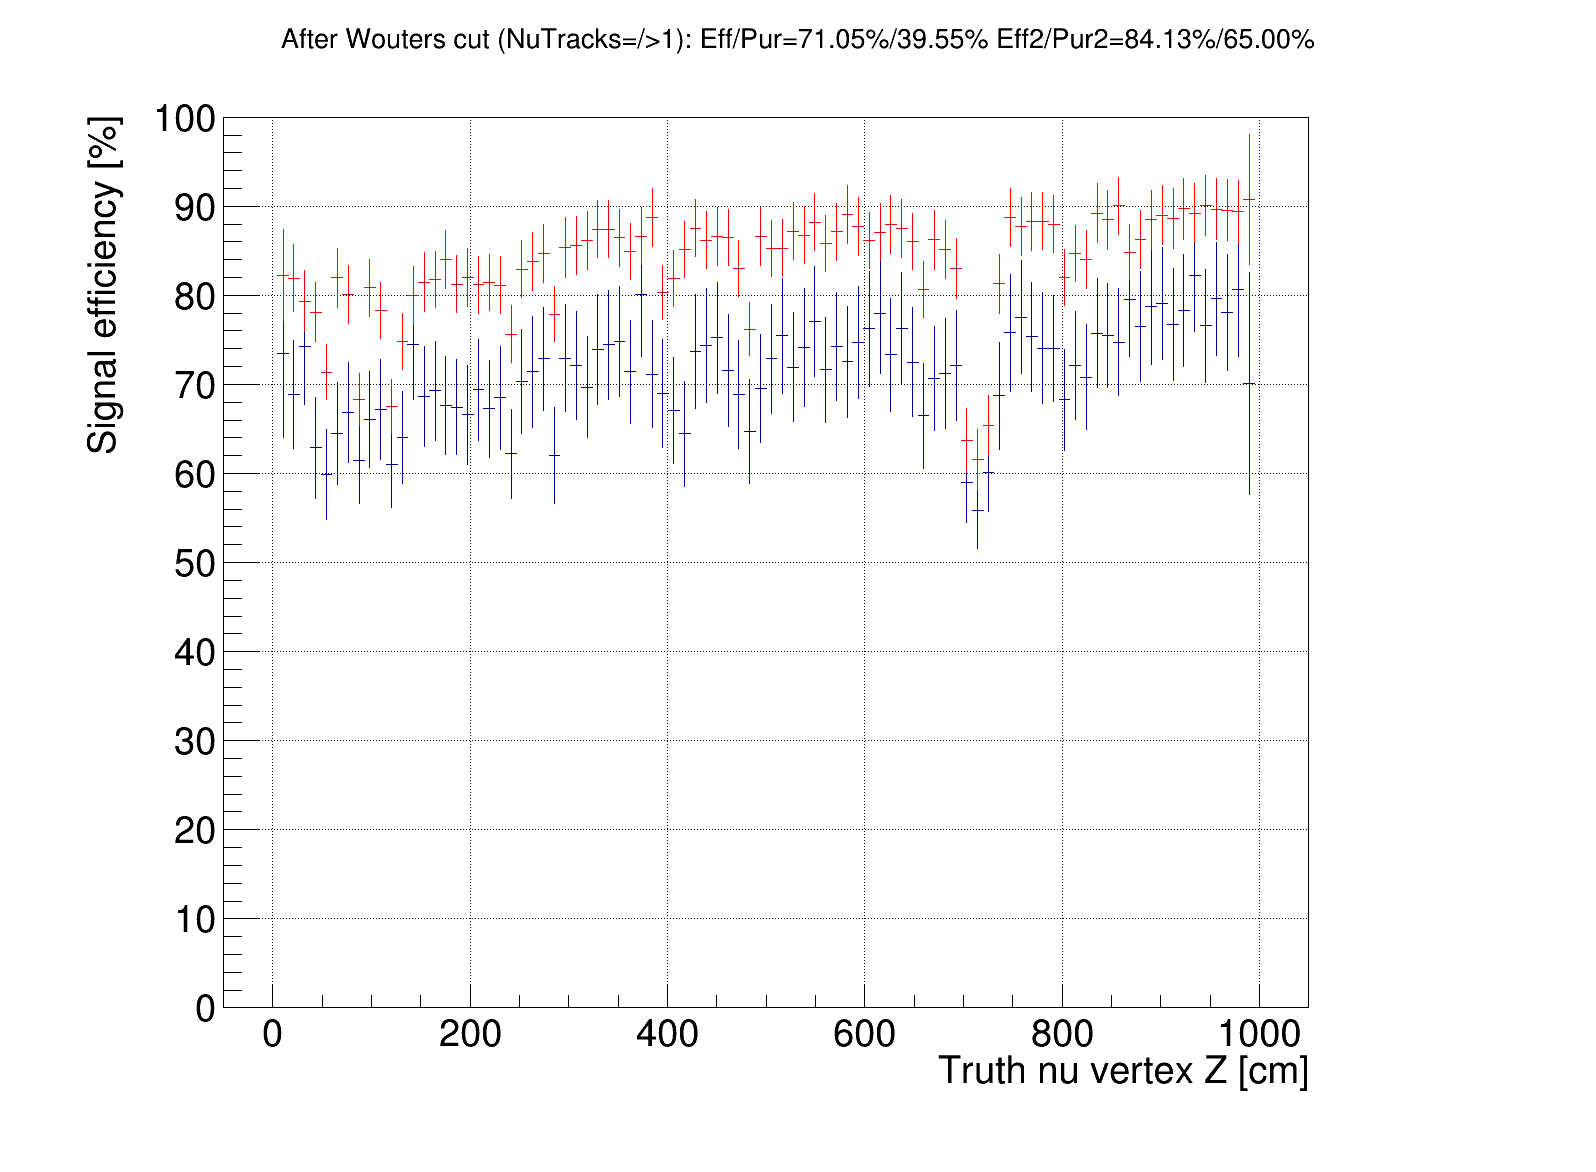

In [31]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && NuTracks==1"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks==1"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks==1'

#efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
#purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && NuTracks>1"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks>1"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks>1'

#efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
#purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_NuTracks'
title = 'After Wouters cut (NuTracks=/>1):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")

